In [2]:
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, RobertaModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    multilabel_confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import argparse
import os
import json
from datetime import datetime

In [3]:
# Add GPU count check at the top level
def get_available_gpus():
    """Get the number of available GPUs and their IDs"""
    if not torch.cuda.is_available():
        return 0, []
    
    n_gpus = torch.cuda.device_count()
    gpu_ids = list(range(n_gpus))
    return n_gpus, gpu_ids

In [4]:
class IssueDataset(Dataset):
    """
    Dataset for processing text data and multi-label classification.

    Args:
        texts (pd.Series): Series of input texts.
        labels (list or pd.Series): Corresponding labels (one-hot encoded for multi-label).
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for converting text to tokens.
        max_length (int): Maximum length of tokenized sequences (default is 512).
    """
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts.reset_index(drop=True)
        # Reset index for labels if it's a pandas Series.
        if isinstance(labels, pd.Series):
            self.labels = labels.reset_index(drop=True)
        else:
            self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        encodings = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        # For multi-label classification, ensure we're passing the full label array
        # and not just a single value
        label = self.labels[idx]
        
        # Make sure we're getting a proper multi-dimensional label array
        # and not flattening it incorrectly
        if isinstance(label, (list, np.ndarray)):
            # Convert directly to tensor without modifying shape
            label = torch.tensor(label, dtype=torch.float)
        else:
            # If it's not already an array-like structure, this is likely a mistake
            # as we expect multi-label one-hot encoded data
            raise ValueError(f"Expected multi-dimensional label array but got {type(label)}")
        
        return {
            'input_ids': encodings['input_ids'].flatten(),
            'attention_mask': encodings['attention_mask'].flatten(),
            'labels': label
        }

In [5]:
class CodeBERTClassifier(nn.Module):
    """
    A classifier model based on CodeBERT for multi-label classification.
    
    This model uses a pre-trained CodeBERT model as the encoder and adds a 
    classification head on top with sigmoid activation for multi-label output.
    
    Args:
        num_labels (int): Number of classes in the multi-label classification task.
    """
    def __init__(self, num_labels):
        super().__init__()
        self.codebert = RobertaModel.from_pretrained('microsoft/codebert-base')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels)
        # Freeze all parameters in CodeBERT
        for param in self.codebert.parameters():
            param.requires_grad = False
        # Unfreeze pooler parameters for fine-tuning
        for param in self.codebert.pooler.parameters():
            param.requires_grad = True
        # Unfreeze parameters of the last 3 encoder layers
        for layer in self.codebert.encoder.layer[-3:]:
            for param in layer.parameters():
                param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.codebert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        # Return raw logits for BCEWithLogitsLoss (sigmoid will be applied in the loss function)
        return self.classifier(pooled_output)


In [6]:
class EarlyStopping:
    """
    Early stopping to stop training when the validation loss does not improve sufficiently.
    
    For multi-label classification, we consider a loss improvement when 
    the validation loss decreases by at least min_delta.
    
    Args:
        patience (int): Number of epochs to wait for an improvement before stopping.
        min_delta (float): Minimum decrease in the monitored loss to qualify as an improvement.
    """
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def reset(self):
        """Reset the early stopping state."""
        self.counter = 0
        self.best_loss = None
        self.early_stop = False


In [7]:
def train_epoch(model, loader, criterion, optimizer, device, threshold=0.5, early_stopping=None):
    """
    Train the model for one epoch, computing loss and metrics for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Training DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        optimizer: Optimization algorithm.
        device: Device to perform training (CPU or GPU).
        threshold (float): Threshold for binary predictions (default is 0.5).
        early_stopping (EarlyStopping, optional): Instance to monitor improvement in loss.

    Returns:
        tuple: Average loss, Hamming accuracy, and a flag indicating if early stopping was triggered.
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch in tqdm(loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        # Apply sigmoid and threshold for predictions
        predictions = torch.sigmoid(outputs) >= threshold
        all_preds.append(predictions.cpu().detach().numpy())
        all_labels.append(labels.cpu().detach().numpy())
    
    # Calculate metrics for multi-label classification
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Use subset accuracy (exact match) for a strict measure
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    
    avg_loss = total_loss / len(loader)
    
    if early_stopping:
        early_stopping(avg_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            return avg_loss, exact_match, True
            
    return avg_loss, exact_match, False
  

In [8]:
def validate(model, loader, criterion, device, threshold=0.5):
    """
    Evaluate the model on provided validation data for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Validation DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        device: Device to perform evaluation.
        threshold (float): Threshold for binary predictions (default is 0.5).

    Returns:
        tuple: Average loss, various accuracy metrics, precision, recall, and F1 score.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Apply sigmoid and threshold for predictions
            predictions = (torch.sigmoid(outputs) >= threshold).float()
            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Calculate different multi-label metrics
    
    # 1. Exact Match / Subset Accuracy (all labels must be correct)
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    
    # 2. Partial Match Accuracy (only count correctly predicted 1s, ignore 0s)
    # Calculate true positives per sample
    true_positives = np.logical_and(all_preds == 1, all_labels == 1).sum(axis=1)
    # Calculate total actual positives per sample
    total_positives = (all_labels == 1).sum(axis=1)
    # Handle division by zero - samples with no positive labels get a score of 0
    partial_match = np.zeros_like(true_positives, dtype=float)
    # Only calculate ratio for samples with at least one positive label
    mask = total_positives > 0
    partial_match[mask] = true_positives[mask] / total_positives[mask]
    partial_match_accuracy = partial_match.mean()
    
    # 3. Jaccard Similarity (intersection over union)
    def jaccard_score(y_true, y_pred):
        intersection = np.logical_and(y_true, y_pred).sum(axis=1)
        union = np.logical_or(y_true, y_pred).sum(axis=1)
        # Create a float array for output to avoid type casting error
        result = np.zeros_like(intersection, dtype=float)
        # Avoid division by zero
        np.divide(intersection, union, out=result, where=union!=0)
        return np.mean(result)
    
    jaccard_sim = jaccard_score(all_labels.astype(bool), all_preds.astype(bool))
    
    # Add Hamming metric - this is the same as partial_match_accuracy
    hamming_sim = partial_match_accuracy
    
    # Sample-based metrics - Each sample contributes equally regardless of number of labels
    precision = precision_score(all_labels, all_preds, average='samples', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='samples', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='samples', zero_division=0)
    
    return (total_loss / len(loader), 
            {"exact_match": exact_match, 
             "partial_match": partial_match_accuracy,
             "hamming": hamming_sim,
             "jaccard": jaccard_sim}, 
            precision, recall, f1)

In [9]:
def plot_multilabel_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrices for each label in a multi-label classification problem.
    
    Args:
        y_true (numpy.ndarray): True binary labels.
        y_pred (numpy.ndarray): Predicted binary labels.
        class_names (list): Names of the classes/labels.
    """
    confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)
    
    num_classes = len(class_names)
    fig, axes = plt.subplots(nrows=(num_classes + 3) // 4, ncols=min(4, num_classes), 
                             figsize=(20, 5 * ((num_classes + 3) // 4)))
    if num_classes == 1:
        axes = np.array([axes])  # Make it indexable for single class
    axes = axes.flatten()
    
    for i, matrix in enumerate(confusion_matrices):
        if i < num_classes:  # Ensure we don't exceed the number of classes
            ax = axes[i]
            sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'Label: {class_names[i]}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.set_xticklabels(['Negative', 'Positive'])
            ax.set_yticklabels(['Negative', 'Positive'])
    
    # Hide any unused subplots
    for i in range(num_classes, len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout()
    return fig

In [10]:
def prepare_data(df, text_column='all_text', min_label_freq=0, max_label_len=100, min_label_comb_freq=0):
    """
    Filter out infrequent labels and samples with too many labels.
    
    Args:
        df (pd.DataFrame): DataFrame with text column and 'labels'
        text_column (str): Name of the column containing the text data to use
        min_label_freq (int): Minimum frequency for a label to be considered frequent.
        max_label_len (int): Maximum number of labels per sample.
        min_label_comb_freq (int): Minimum frequency for a label combination to be kept.

    Returns:
        tuple: Filtered texts and labels.
    """
    # Only keep text column and 'labels' columns
    if text_column in df.columns:
        df = df[[text_column, 'labels']]
        # Filter out rows with 'nan' text
        df = df[~df[text_column].apply(lambda x: x.startswith('nan') if isinstance(x, str) else False)]
    else:
        raise ValueError(f"Text column '{text_column}' not found in the DataFrame. Available columns: {df.columns.tolist()}")
    
    # Drop rows with missing labels
    df = df.dropna()
    
    # Extract issue texts and labels
    texts = df[text_column]
    labels = df['labels'].apply(lambda x: x if isinstance(x, list) else [])  # Ensure labels are lists

    # Get labels count distribution
    label_distribution = Counter([label for labels in labels for label in labels])

    # Labels to keep based on frequency
    frequent_labels = [label for label, count in label_distribution.items() if count >= min_label_freq]
    print(f"Number of labels with at least {min_label_freq} occurrences: {len(frequent_labels)}")
    print(f"Removed {len(label_distribution) - len(frequent_labels)} infrequent labels")

    # Filter out infrequent labels
    filtered_labels = labels.apply(lambda x: [label for label in x if label in frequent_labels])
    print(f"Number of samples after filtering: {len(filtered_labels)}")

    # Get label combinations distribution
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    frequent_combinations = {labels: count for labels, count in label_combinations.items() if count >= min_label_comb_freq}
    print(f"Number of label combinations with at least {min_label_comb_freq} occurrences: {len(frequent_combinations)}")
    print(f"Removed {len(label_combinations) - len(frequent_combinations)} infrequent label combinations")
    
    # Create mask for samples with frequent label combinations (if min_label_comb_freq > 0)
    if min_label_comb_freq > 0:
        comb_mask = filtered_labels.apply(lambda x: tuple(sorted(x)) in frequent_combinations)
        print(f"Number of samples with frequent label combinations: {comb_mask.sum()}")
    else:
        comb_mask = pd.Series([True] * len(filtered_labels))
    
    # Filter by label length
    label_length = filtered_labels.apply(len)
    length_mask = (label_length > 0) & (label_length <= max_label_len)
    
    # Combine both masks
    final_mask = comb_mask & length_mask
    
    # Now get the final filtered texts and labels
    texts = texts[final_mask].reset_index(drop=True)
    filtered_labels = filtered_labels[final_mask].reset_index(drop=True)
    
    print(f"Final number of samples after all filtering: {len(filtered_labels)}")
    
    return texts, filtered_labels

In [11]:
def main(args):
    """
    Main function to run the multi-label classification pipeline with CodeBERT.
    This function loads data, preprocesses it, trains the model, and evaluates performance.
    """
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Check for GPU availability
    n_gpus, gpu_ids = get_available_gpus()
    if n_gpus >= 2:
        print(f"Using {n_gpus} GPUs: {gpu_ids}")
        device = torch.device("cuda")
        use_multi_gpu = True
    elif n_gpus == 1:
        print("Using 1 GPU")
        device = torch.device("cuda")
        use_multi_gpu = False
    else:
        print("No GPUs available, using CPU")
        device = torch.device("cpu")
        use_multi_gpu = False
    
    # Make results directory if it doesn't exist
    results_dir = args.results_dir
    os.makedirs(results_dir, exist_ok=True)
    
    # Create a timestamped directory for this run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(results_dir, f"run_{timestamp}_{args.text_column}")
    os.makedirs(run_dir, exist_ok=True)
    
    # Load data
    print(f"Loading data from {args.data_path}...")
    df = pd.read_json(args.data_path)
    
    # Check if the text column exists
    if args.text_column not in df.columns:
        available_columns = [col for col in df.columns if col.startswith('all_text')]
        print(f"Text column '{args.text_column}' not found. Available text columns: {available_columns}")
        if len(available_columns) == 0:
            raise ValueError("No text columns found in the data")
        args.text_column = available_columns[0]
        print(f"Using '{args.text_column}' instead")
    
    # Use prepare_data function to filter and prepare data
    texts, filtered_labels = prepare_data(
        df, 
        text_column=args.text_column,
        min_label_freq=args.min_label_freq, 
        max_label_len=args.max_label_len, 
        min_label_comb_freq=args.min_label_comb_freq
    )
    
    # Count the number of labels distribution
    label_distribution = Counter([label for labels in filtered_labels for label in labels])
    print('\n Label Distribution : ')
    for i, (label, count) in enumerate(sorted(label_distribution.items(), key=lambda x: x[1], reverse=True)):
        print(f'{i}. {label}: {count}')
    
    # Count the label length distribution
    label_length_distribution = Counter([len(labels) for labels in filtered_labels])
    print('\n Label count per row distribution:')
    for label in sorted(label_length_distribution.keys()):
        print(f'Label: {label}, count: {label_length_distribution[label]}')

    # Count the distribution of label combinations
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    print('\n Label combinations distribution:')
    for i, (labels, count) in enumerate(sorted(label_combinations.items(), key=lambda x: x[1], reverse=True)):
        if i < 20:  # Show only the top 20 combinations
            print(f'{i}. Label combination: {labels}, count: {count}')
    
    # Encode multi-labels using MultiLabelBinarizer
    print("Encoding labels...")
    mlb = MultiLabelBinarizer()
    labels_encoded = mlb.fit_transform(filtered_labels)
    
    # Save label encoder for future use
    with open(os.path.join(run_dir, 'label_encoder.json'), 'w') as f:
        json.dump({
            'classes': mlb.classes_.tolist()
        }, f)
    
    # Calculate label distribution
    label_counts = labels_encoded.sum(axis=0)
    
    # Log class imbalance metrics
    label_density = label_counts.sum() / (labels_encoded.shape[0] * labels_encoded.shape[1])
    print(f"Label density: {label_density:.4f}")
    print(f"Average labels per sample: {label_counts.sum() / labels_encoded.shape[0]:.2f}")
    
    # Split data into training and validation sets (80% training, 20% validation)
    split_idx = int(len(texts) * 0.8)
    train_texts, val_texts = texts[:split_idx], texts[split_idx:]
    train_labels, val_labels = labels_encoded[:split_idx], labels_encoded[split_idx:]
    
    print(f"Training samples: {len(train_texts)}, Validation samples: {len(val_texts)}")
    
    # Initialize tokenizer
    print("Loading tokenizer...")
    tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
    
    # Implement class weights for loss function to handle imbalance
    pos_weights = None
    if args.use_class_weights and label_counts.min() < label_counts.max() / 5:  # If there's significant imbalance
        print("Computing class weights for imbalanced labels...")
        pos_weights = torch.FloatTensor(
            (labels_encoded.shape[0] - label_counts) / label_counts
        ).clamp(0.5, 10).to(device)  # Limit range to prevent extreme weights
    
    # Create datasets and dataloaders
    batch_size = args.batch_size
    train_dataset = IssueDataset(train_texts, train_labels, tokenizer)
    val_dataset = IssueDataset(val_texts, val_labels, tokenizer)
    
    # Increase batch size for DataParallel if multiple GPUs
    if use_multi_gpu:
        batch_size = batch_size * n_gpus
        print(f"Using larger batch size of {batch_size} for {n_gpus} GPUs")
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model, loss function, and optimizer
    print("Initializing model...")
    model = CodeBERTClassifier(num_labels=len(mlb.classes_)).to(device)
    
    # Use DataParallel for multiple GPUs
    if use_multi_gpu:
        model = nn.DataParallel(model)
        print("Model wrapped in DataParallel")
    
    # Use weighted loss if we have weights
    if pos_weights is not None:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
        print("Using weighted BCE loss")
    else:
        criterion = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=args.patience, min_delta=0.01)
    
    # Training loop
    num_epochs = args.epochs
    print(f"Starting training for {num_epochs} epochs...")
    
    train_losses = []
    val_losses = []
    best_f1 = 0.0
    best_model_saved = False  # Flag to track if we've saved at least one model
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train for one epoch
        train_loss, train_acc, stop_early = train_epoch(
            model, train_loader, criterion, optimizer, device, early_stopping=early_stopping
        )
        
        # Validate
        val_loss, accuracy_metrics, val_precision, val_recall, val_f1 = validate(
            model, val_loader, criterion, device
        )
        
        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy (Exact Match): {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Val Accuracy (Exact Match): {accuracy_metrics['exact_match']:.4f}")
        print(f"Val Accuracy (Partial Match): {accuracy_metrics['partial_match']:.4f}")
        print(f"Val Accuracy (Jaccard): {accuracy_metrics['jaccard']:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        
        # Save best model based on F1 score
        model_path = os.path.join(run_dir, f'best_model_{args.text_column}.pt')
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            
            # Save the model state_dict (handle DataParallel wrapper if needed)
            if use_multi_gpu:
                torch.save(model.module.state_dict(), model_path)
            else:
                torch.save(model.state_dict(), model_path)
                
            print(f"Saved new best model to {model_path}")
            best_model_saved = True
        
        # Always save a model for the first epoch if no model has been saved yet
        # This ensures we have at least one model if early stopping occurs
        if epoch == 0 and not best_model_saved:
            if use_multi_gpu:
                torch.save(model.module.state_dict(), model_path)
            else:
                torch.save(model.state_dict(), model_path)
            print(f"Saved initial model to {model_path} as baseline")
            best_model_saved = True
            
        # Check for early stopping
        if stop_early:
            print("Early stopping triggered. Terminating training.")
            break
    
    # Save training history
    history = {
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    with open(os.path.join(run_dir, 'training_history.json'), 'w') as f:
        json.dump(history, f)
    
    # Load best model for final evaluation
    print("\nLoading best model for final evaluation...")
    best_model_path = os.path.join(run_dir, f'best_model_{args.text_column}.pt')
    
    # Handle loading for DataParallel model
    if use_multi_gpu:
        model.module.load_state_dict(torch.load(best_model_path))
    else:
        model.load_state_dict(torch.load(best_model_path))
    
    # Evaluate the model with default threshold
    print("\nFinal evaluation with default threshold (0.5):")
    final_loss, final_acc_metrics, final_precision, final_recall, final_f1 = validate(
        model, val_loader, criterion, device
    )
    
    print(f"Exact Match Accuracy: {final_acc_metrics['exact_match']:.4f}")
    print(f"Partial Match Accuracy: {final_acc_metrics['partial_match']:.4f}")
    print(f"Jaccard Similarity: {final_acc_metrics['jaccard']:.4f}")
    print(f"Precision: {final_precision:.4f}")
    print(f"Recall: {final_recall:.4f}")
    print(f"F1 Score: {final_f1:.4f}")
    
    # Save results
    results = {
        'text_column': args.text_column,
        'metrics': {
            'exact_match': float(final_acc_metrics['exact_match']),
            'partial_match': float(final_acc_metrics['partial_match']),
            'jaccard': float(final_acc_metrics['jaccard']),
            'precision': float(final_precision),
            'recall': float(final_recall), 
            'f1': float(final_f1),
        }
    }
    with open(os.path.join(run_dir, 'results.json'), 'w') as f:
        json.dump(results, f, indent=4)
    
    # Collect predictions with default threshold for confusion matrices
    model.eval()
    all_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids, attention_mask)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            
            all_preds.append(preds.cpu().numpy())
            all_val_labels.append(batch['labels'].numpy())
    
    all_preds = np.vstack(all_preds)
    all_val_labels = np.vstack(all_val_labels)
    
    # Plot and save confusion matrices (up to 20 labels to avoid too many plots)
    num_labels_to_plot = min(20, len(mlb.classes_))
    fig = plot_multilabel_confusion_matrix(
        all_val_labels[:, :num_labels_to_plot], 
        all_preds[:, :num_labels_to_plot], 
        mlb.classes_[:num_labels_to_plot]
    )
    plt.savefig(os.path.join(run_dir, 'confusion_matrices.png'))
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training History - {args.text_column}')
    plt.legend()
    plt.savefig(os.path.join(run_dir, 'training_history.png'))
    
    print(f"\nTraining completed! Results saved to {run_dir}")
    
    return {
        'metrics': results['metrics'],
        'model': model,
        'label_encoder': mlb,
        'results_dir': run_dir
    }


# Removing Most Frequent Words

## Threshold 0.5

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-bug-with-reduced-comments-0-3/cleaned_data_with_changed_files_reduced_comments.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 0 occurrences: 109
Removed 0 infrequent label combinations
Final number of samples after all filtering: 1222

 Label Distribution : 
0. area/kubelet: 372
1. area/test: 326
2. area/apiserver: 223
3. area/cloudprovider: 194
4. area/kubectl: 145
5. area/dependency: 77
6. area/provider/azure: 67
7. area/code-generation: 54
8. area/kubeadm: 47
9. area/ipvs: 47
10. area/kube-proxy: 30
11. area/provider/gcp: 29
12. area/e2e-test-framework: 23
13. area/release-eng: 18
14. area/conformance: 16
15. area/custom-resources: 16
16. area/security: 11
17. area/provider/vmware: 6
18. area/etcd: 5
19. area/provider/openstack: 5

 Label count per row distribution:
Label: 1, count: 888
Label: 2, cou

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

Using larger batch size of 32 for 2 GPUs
Initializing model...


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Model wrapped in DataParallel
Starting training for 20 epochs...

Epoch 1/20


Training: 100%|██████████| 31/31 [00:30<00:00,  1.00it/s]


Train Loss: 0.4911, Train Accuracy (Exact Match): 0.0123
Val Loss: 0.3141
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Saved initial model to ./results/run_20250318_132952_all_text_0.5/best_model_all_text_0.5.pt as baseline

Epoch 2/20


Training: 100%|██████████| 31/31 [00:29<00:00,  1.06it/s]


Train Loss: 0.2810, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2380
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Train Loss: 0.2356, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2182
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 31/31 [00:33<00:00,  1.07s/it]


Train Loss: 0.2209, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2111
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 31/31 [00:31<00:00,  1.03s/it]


Train Loss: 0.2128, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2069
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 6/20


Training: 100%|██████████| 31/31 [00:33<00:00,  1.07s/it]


Train Loss: 0.2062, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2030
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 7/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1982, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.1988
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0054
Val Accuracy (Jaccard): 0.0054
Val Precision: 0.0082, Val Recall: 0.0054, Val F1: 0.0065
Saved new best model to ./results/run_20250318_132952_all_text_0.5/best_model_all_text_0.5.pt

Epoch 8/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1876, Train Accuracy (Exact Match): 0.0450
Val Loss: 0.1921
Val Accuracy (Exact Match): 0.2163
Val Accuracy (Partial Match): 0.2328
Val Accuracy (Jaccard): 0.2328
Val Precision: 0.2571, Val Recall: 0.2328, Val F1: 0.2395
Saved new best model to ./results/run_20250318_132952_all_text_0.5/best_model_all_text_0.5.pt

Epoch 9/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1749, Train Accuracy (Exact Match): 0.2006
Val Loss: 0.1836
Val Accuracy (Exact Match): 0.2612
Val Accuracy (Partial Match): 0.3035
Val Accuracy (Jaccard): 0.2984
Val Precision: 0.3378, Val Recall: 0.3035, Val F1: 0.3115
Saved new best model to ./results/run_20250318_132952_all_text_0.5/best_model_all_text_0.5.pt

Epoch 10/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]


Train Loss: 0.1632, Train Accuracy (Exact Match): 0.2631
Val Loss: 0.1769
Val Accuracy (Exact Match): 0.2776
Val Accuracy (Partial Match): 0.3498
Val Accuracy (Jaccard): 0.3345
Val Precision: 0.3847, Val Recall: 0.3498, Val F1: 0.3544
Saved new best model to ./results/run_20250318_132952_all_text_0.5/best_model_all_text_0.5.pt

Epoch 11/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1517, Train Accuracy (Exact Match): 0.3541
Val Loss: 0.1700
Val Accuracy (Exact Match): 0.3265
Val Accuracy (Partial Match): 0.4076
Val Accuracy (Jaccard): 0.3896
Val Precision: 0.4418, Val Recall: 0.4076, Val F1: 0.4115
Saved new best model to ./results/run_20250318_132952_all_text_0.5/best_model_all_text_0.5.pt

Epoch 12/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1413, Train Accuracy (Exact Match): 0.4258
Val Loss: 0.1615
Val Accuracy (Exact Match): 0.3592
Val Accuracy (Partial Match): 0.4650
Val Accuracy (Jaccard): 0.4381
Val Precision: 0.4969, Val Recall: 0.4650, Val F1: 0.4655
Saved new best model to ./results/run_20250318_132952_all_text_0.5/best_model_all_text_0.5.pt

Epoch 13/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1314, Train Accuracy (Exact Match): 0.4964
Val Loss: 0.1562
Val Accuracy (Exact Match): 0.3592
Val Accuracy (Partial Match): 0.4748
Val Accuracy (Jaccard): 0.4438
Val Precision: 0.5105, Val Recall: 0.4748, Val F1: 0.4737
Saved new best model to ./results/run_20250318_132952_all_text_0.5/best_model_all_text_0.5.pt

Epoch 14/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1215, Train Accuracy (Exact Match): 0.5292
Val Loss: 0.1529
Val Accuracy (Exact Match): 0.4041
Val Accuracy (Partial Match): 0.5353
Val Accuracy (Jaccard): 0.4972
Val Precision: 0.5643, Val Recall: 0.5353, Val F1: 0.5304
Saved new best model to ./results/run_20250318_132952_all_text_0.5/best_model_all_text_0.5.pt

Epoch 15/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]


Train Loss: 0.1139, Train Accuracy (Exact Match): 0.5793
Val Loss: 0.1508
Val Accuracy (Exact Match): 0.4204
Val Accuracy (Partial Match): 0.5401
Val Accuracy (Jaccard): 0.5084
Val Precision: 0.5806, Val Recall: 0.5401, Val F1: 0.5404
Saved new best model to ./results/run_20250318_132952_all_text_0.5/best_model_all_text_0.5.pt

Epoch 16/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Train Loss: 0.1079, Train Accuracy (Exact Match): 0.5988
Val Loss: 0.1490
Val Accuracy (Exact Match): 0.4122
Val Accuracy (Partial Match): 0.5503
Val Accuracy (Jaccard): 0.5085
Val Precision: 0.5800, Val Recall: 0.5503, Val F1: 0.5440
Saved new best model to ./results/run_20250318_132952_all_text_0.5/best_model_all_text_0.5.pt

Epoch 17/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]


Train Loss: 0.1017, Train Accuracy (Exact Match): 0.6131
Val Loss: 0.1485
Val Accuracy (Exact Match): 0.4204
Val Accuracy (Partial Match): 0.5665
Val Accuracy (Jaccard): 0.5212
Val Precision: 0.5929, Val Recall: 0.5665, Val F1: 0.5582
Saved new best model to ./results/run_20250318_132952_all_text_0.5/best_model_all_text_0.5.pt

Epoch 18/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.0954, Train Accuracy (Exact Match): 0.6172
Val Loss: 0.1445
Val Accuracy (Exact Match): 0.4653
Val Accuracy (Partial Match): 0.6012
Val Accuracy (Jaccard): 0.5594
Val Precision: 0.6249, Val Recall: 0.6012, Val F1: 0.5937
Saved new best model to ./results/run_20250318_132952_all_text_0.5/best_model_all_text_0.5.pt

Epoch 19/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]


Train Loss: 0.0898, Train Accuracy (Exact Match): 0.6571
Val Loss: 0.1426
Val Accuracy (Exact Match): 0.4857
Val Accuracy (Partial Match): 0.6278
Val Accuracy (Jaccard): 0.5813
Val Precision: 0.6487, Val Recall: 0.6278, Val F1: 0.6169
Saved new best model to ./results/run_20250318_132952_all_text_0.5/best_model_all_text_0.5.pt

Epoch 20/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.0865, Train Accuracy (Exact Match): 0.6561
Val Loss: 0.1416
Val Accuracy (Exact Match): 0.4898
Val Accuracy (Partial Match): 0.6489
Val Accuracy (Jaccard): 0.5966
Val Precision: 0.6688, Val Recall: 0.6489, Val F1: 0.6354
Saved new best model to ./results/run_20250318_132952_all_text_0.5/best_model_all_text_0.5.pt

Loading best model for final evaluation...


<ipython-input-11-1606e2bcbdc8>:224: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.4898
Partial Match Accuracy: 0.6489
Jaccard Similarity: 0.5966
Precision: 0.6688
Recall: 0.6489
F1 Score: 0.6354

Training completed! Results saved to ./results/run_20250318_132952_all_text_0.5


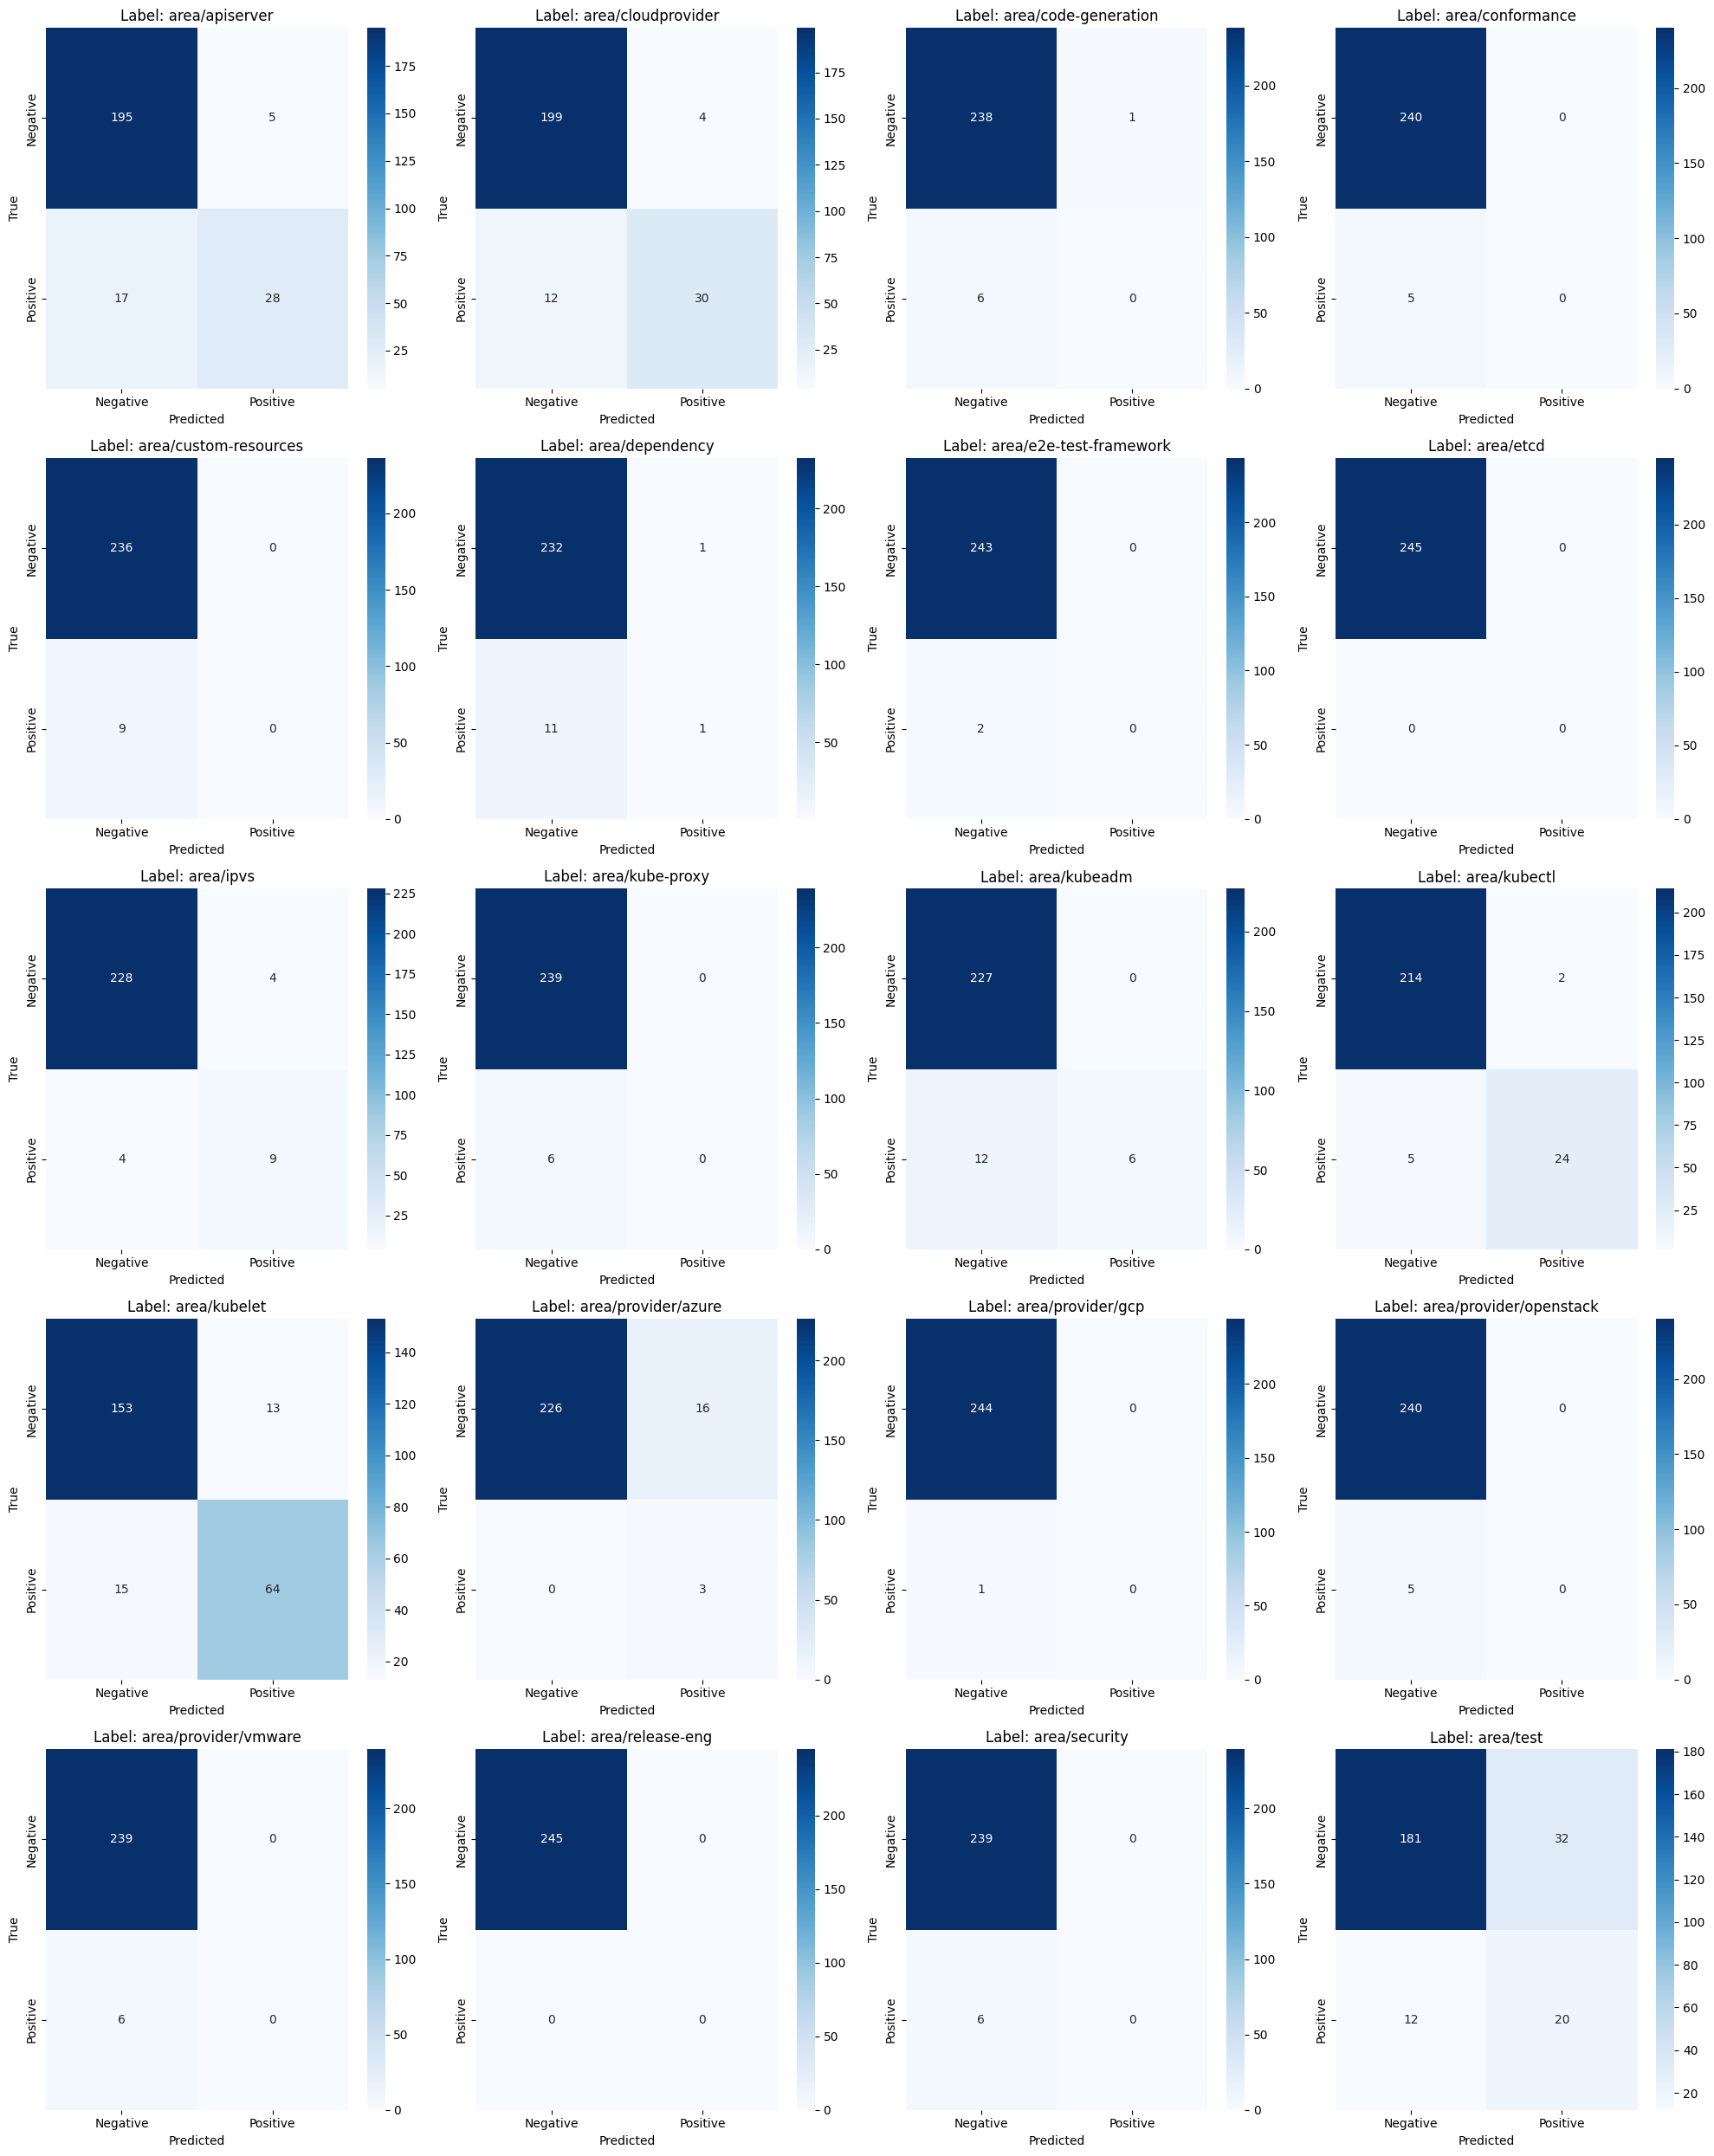

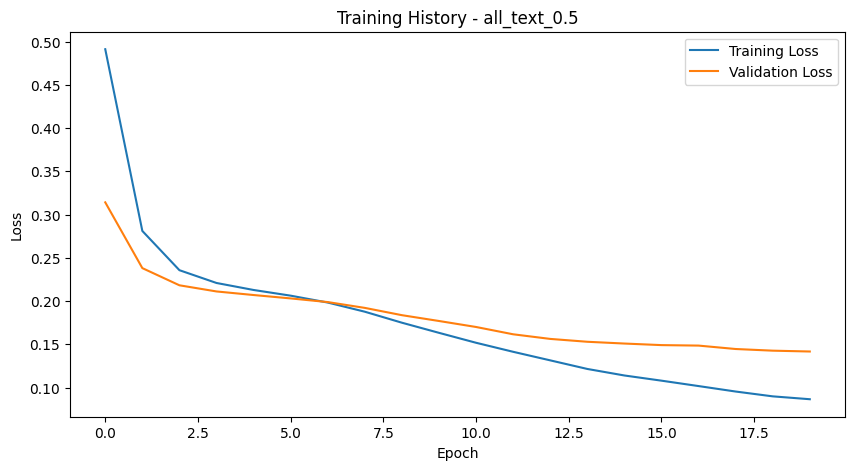

In [12]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train CodeBERT for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-bug-with-reduced-comments-0-3/cleaned_data_with_changed_files_reduced_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.5',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=0,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

## Threshold 0.6

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-bug-with-reduced-comments-0-3/cleaned_data_with_changed_files_reduced_comments.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 0 occurrences: 109
Removed 0 infrequent label combinations
Final number of samples after all filtering: 1222

 Label Distribution : 
0. area/kubelet: 372
1. area/test: 326
2. area/apiserver: 223
3. area/cloudprovider: 194
4. area/kubectl: 145
5. area/dependency: 77
6. area/provider/azure: 67
7. area/code-generation: 54
8. area/kubeadm: 47
9. area/ipvs: 47
10. area/kube-proxy: 30
11. area/provider/gcp: 29
12. area/e2e-test-framework: 23
13. area/release-eng: 18
14. area/conformance: 16
15. area/custom-resources: 16
16. area/security: 11
17. area/provider/vmware: 6
18. area/etcd: 5
19. area/provider/openstack: 5

 Label count per row distribution:
Label: 1, count: 888
Label: 2, cou

Training: 100%|██████████| 31/31 [00:33<00:00,  1.09s/it]


Train Loss: 0.4910, Train Accuracy (Exact Match): 0.0113
Val Loss: 0.3141
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Saved initial model to ./results/run_20250318_134314_all_text_0.6/best_model_all_text_0.6.pt as baseline

Epoch 2/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]


Train Loss: 0.2809, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2380
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]


Train Loss: 0.2356, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2182
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.2209, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2111
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]


Train Loss: 0.2128, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2070
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 6/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.2063, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2031
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 7/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]


Train Loss: 0.1985, Train Accuracy (Exact Match): 0.0010
Val Loss: 0.1987
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0054
Val Accuracy (Jaccard): 0.0054
Val Precision: 0.0082, Val Recall: 0.0054, Val F1: 0.0065
Saved new best model to ./results/run_20250318_134314_all_text_0.6/best_model_all_text_0.6.pt

Epoch 8/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Train Loss: 0.1880, Train Accuracy (Exact Match): 0.0481
Val Loss: 0.1920
Val Accuracy (Exact Match): 0.2163
Val Accuracy (Partial Match): 0.2355
Val Accuracy (Jaccard): 0.2355
Val Precision: 0.2612, Val Recall: 0.2355, Val F1: 0.2427
Saved new best model to ./results/run_20250318_134314_all_text_0.6/best_model_all_text_0.6.pt

Epoch 9/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1744, Train Accuracy (Exact Match): 0.1955
Val Loss: 0.1835
Val Accuracy (Exact Match): 0.2571
Val Accuracy (Partial Match): 0.2940
Val Accuracy (Jaccard): 0.2910
Val Precision: 0.3276, Val Recall: 0.2940, Val F1: 0.3027
Saved new best model to ./results/run_20250318_134314_all_text_0.6/best_model_all_text_0.6.pt

Epoch 10/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1631, Train Accuracy (Exact Match): 0.2610
Val Loss: 0.1773
Val Accuracy (Exact Match): 0.2980
Val Accuracy (Partial Match): 0.3763
Val Accuracy (Jaccard): 0.3576
Val Precision: 0.4071, Val Recall: 0.3763, Val F1: 0.3789
Saved new best model to ./results/run_20250318_134314_all_text_0.6/best_model_all_text_0.6.pt

Epoch 11/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1519, Train Accuracy (Exact Match): 0.3501
Val Loss: 0.1710
Val Accuracy (Exact Match): 0.3224
Val Accuracy (Partial Match): 0.4015
Val Accuracy (Jaccard): 0.3835
Val Precision: 0.4337, Val Recall: 0.4015, Val F1: 0.4047
Saved new best model to ./results/run_20250318_134314_all_text_0.6/best_model_all_text_0.6.pt

Epoch 12/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]


Train Loss: 0.1414, Train Accuracy (Exact Match): 0.4237
Val Loss: 0.1623
Val Accuracy (Exact Match): 0.3551
Val Accuracy (Partial Match): 0.4483
Val Accuracy (Jaccard): 0.4255
Val Precision: 0.4765, Val Recall: 0.4483, Val F1: 0.4496
Saved new best model to ./results/run_20250318_134314_all_text_0.6/best_model_all_text_0.6.pt

Epoch 13/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1312, Train Accuracy (Exact Match): 0.4964
Val Loss: 0.1566
Val Accuracy (Exact Match): 0.3469
Val Accuracy (Partial Match): 0.4676
Val Accuracy (Jaccard): 0.4346
Val Precision: 0.4990, Val Recall: 0.4676, Val F1: 0.4653
Saved new best model to ./results/run_20250318_134314_all_text_0.6/best_model_all_text_0.6.pt

Epoch 14/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1211, Train Accuracy (Exact Match): 0.5384
Val Loss: 0.1520
Val Accuracy (Exact Match): 0.3755
Val Accuracy (Partial Match): 0.5088
Val Accuracy (Jaccard): 0.4693
Val Precision: 0.5398, Val Recall: 0.5088, Val F1: 0.5040
Saved new best model to ./results/run_20250318_134314_all_text_0.6/best_model_all_text_0.6.pt

Epoch 15/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]


Train Loss: 0.1138, Train Accuracy (Exact Match): 0.5711
Val Loss: 0.1504
Val Accuracy (Exact Match): 0.3918
Val Accuracy (Partial Match): 0.5244
Val Accuracy (Jaccard): 0.4863
Val Precision: 0.5561, Val Recall: 0.5244, Val F1: 0.5202
Saved new best model to ./results/run_20250318_134314_all_text_0.6/best_model_all_text_0.6.pt

Epoch 16/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1070, Train Accuracy (Exact Match): 0.6059
Val Loss: 0.1494
Val Accuracy (Exact Match): 0.4245
Val Accuracy (Partial Match): 0.5605
Val Accuracy (Jaccard): 0.5200
Val Precision: 0.5908, Val Recall: 0.5605, Val F1: 0.5547
Saved new best model to ./results/run_20250318_134314_all_text_0.6/best_model_all_text_0.6.pt

Epoch 17/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]


Train Loss: 0.1010, Train Accuracy (Exact Match): 0.6141
Val Loss: 0.1482
Val Accuracy (Exact Match): 0.4000
Val Accuracy (Partial Match): 0.5297
Val Accuracy (Jaccard): 0.4920
Val Precision: 0.5622, Val Recall: 0.5297, Val F1: 0.5255

Epoch 18/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Train Loss: 0.0958, Train Accuracy (Exact Match): 0.6203
Val Loss: 0.1443
Val Accuracy (Exact Match): 0.4408
Val Accuracy (Partial Match): 0.5773
Val Accuracy (Jaccard): 0.5335
Val Precision: 0.5984, Val Recall: 0.5773, Val F1: 0.5680
Saved new best model to ./results/run_20250318_134314_all_text_0.6/best_model_all_text_0.6.pt

Epoch 19/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.0898, Train Accuracy (Exact Match): 0.6561
Val Loss: 0.1432
Val Accuracy (Exact Match): 0.4612
Val Accuracy (Partial Match): 0.5945
Val Accuracy (Jaccard): 0.5554
Val Precision: 0.6276, Val Recall: 0.5945, Val F1: 0.5902
Saved new best model to ./results/run_20250318_134314_all_text_0.6/best_model_all_text_0.6.pt

Epoch 20/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.0859, Train Accuracy (Exact Match): 0.6561
Val Loss: 0.1417
Val Accuracy (Exact Match): 0.4857
Val Accuracy (Partial Match): 0.6467
Val Accuracy (Jaccard): 0.5931
Val Precision: 0.6616, Val Recall: 0.6467, Val F1: 0.6322
Saved new best model to ./results/run_20250318_134314_all_text_0.6/best_model_all_text_0.6.pt

Loading best model for final evaluation...


<ipython-input-11-1606e2bcbdc8>:224: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.4857
Partial Match Accuracy: 0.6467
Jaccard Similarity: 0.5931
Precision: 0.6616
Recall: 0.6467
F1 Score: 0.6322

Training completed! Results saved to ./results/run_20250318_134314_all_text_0.6


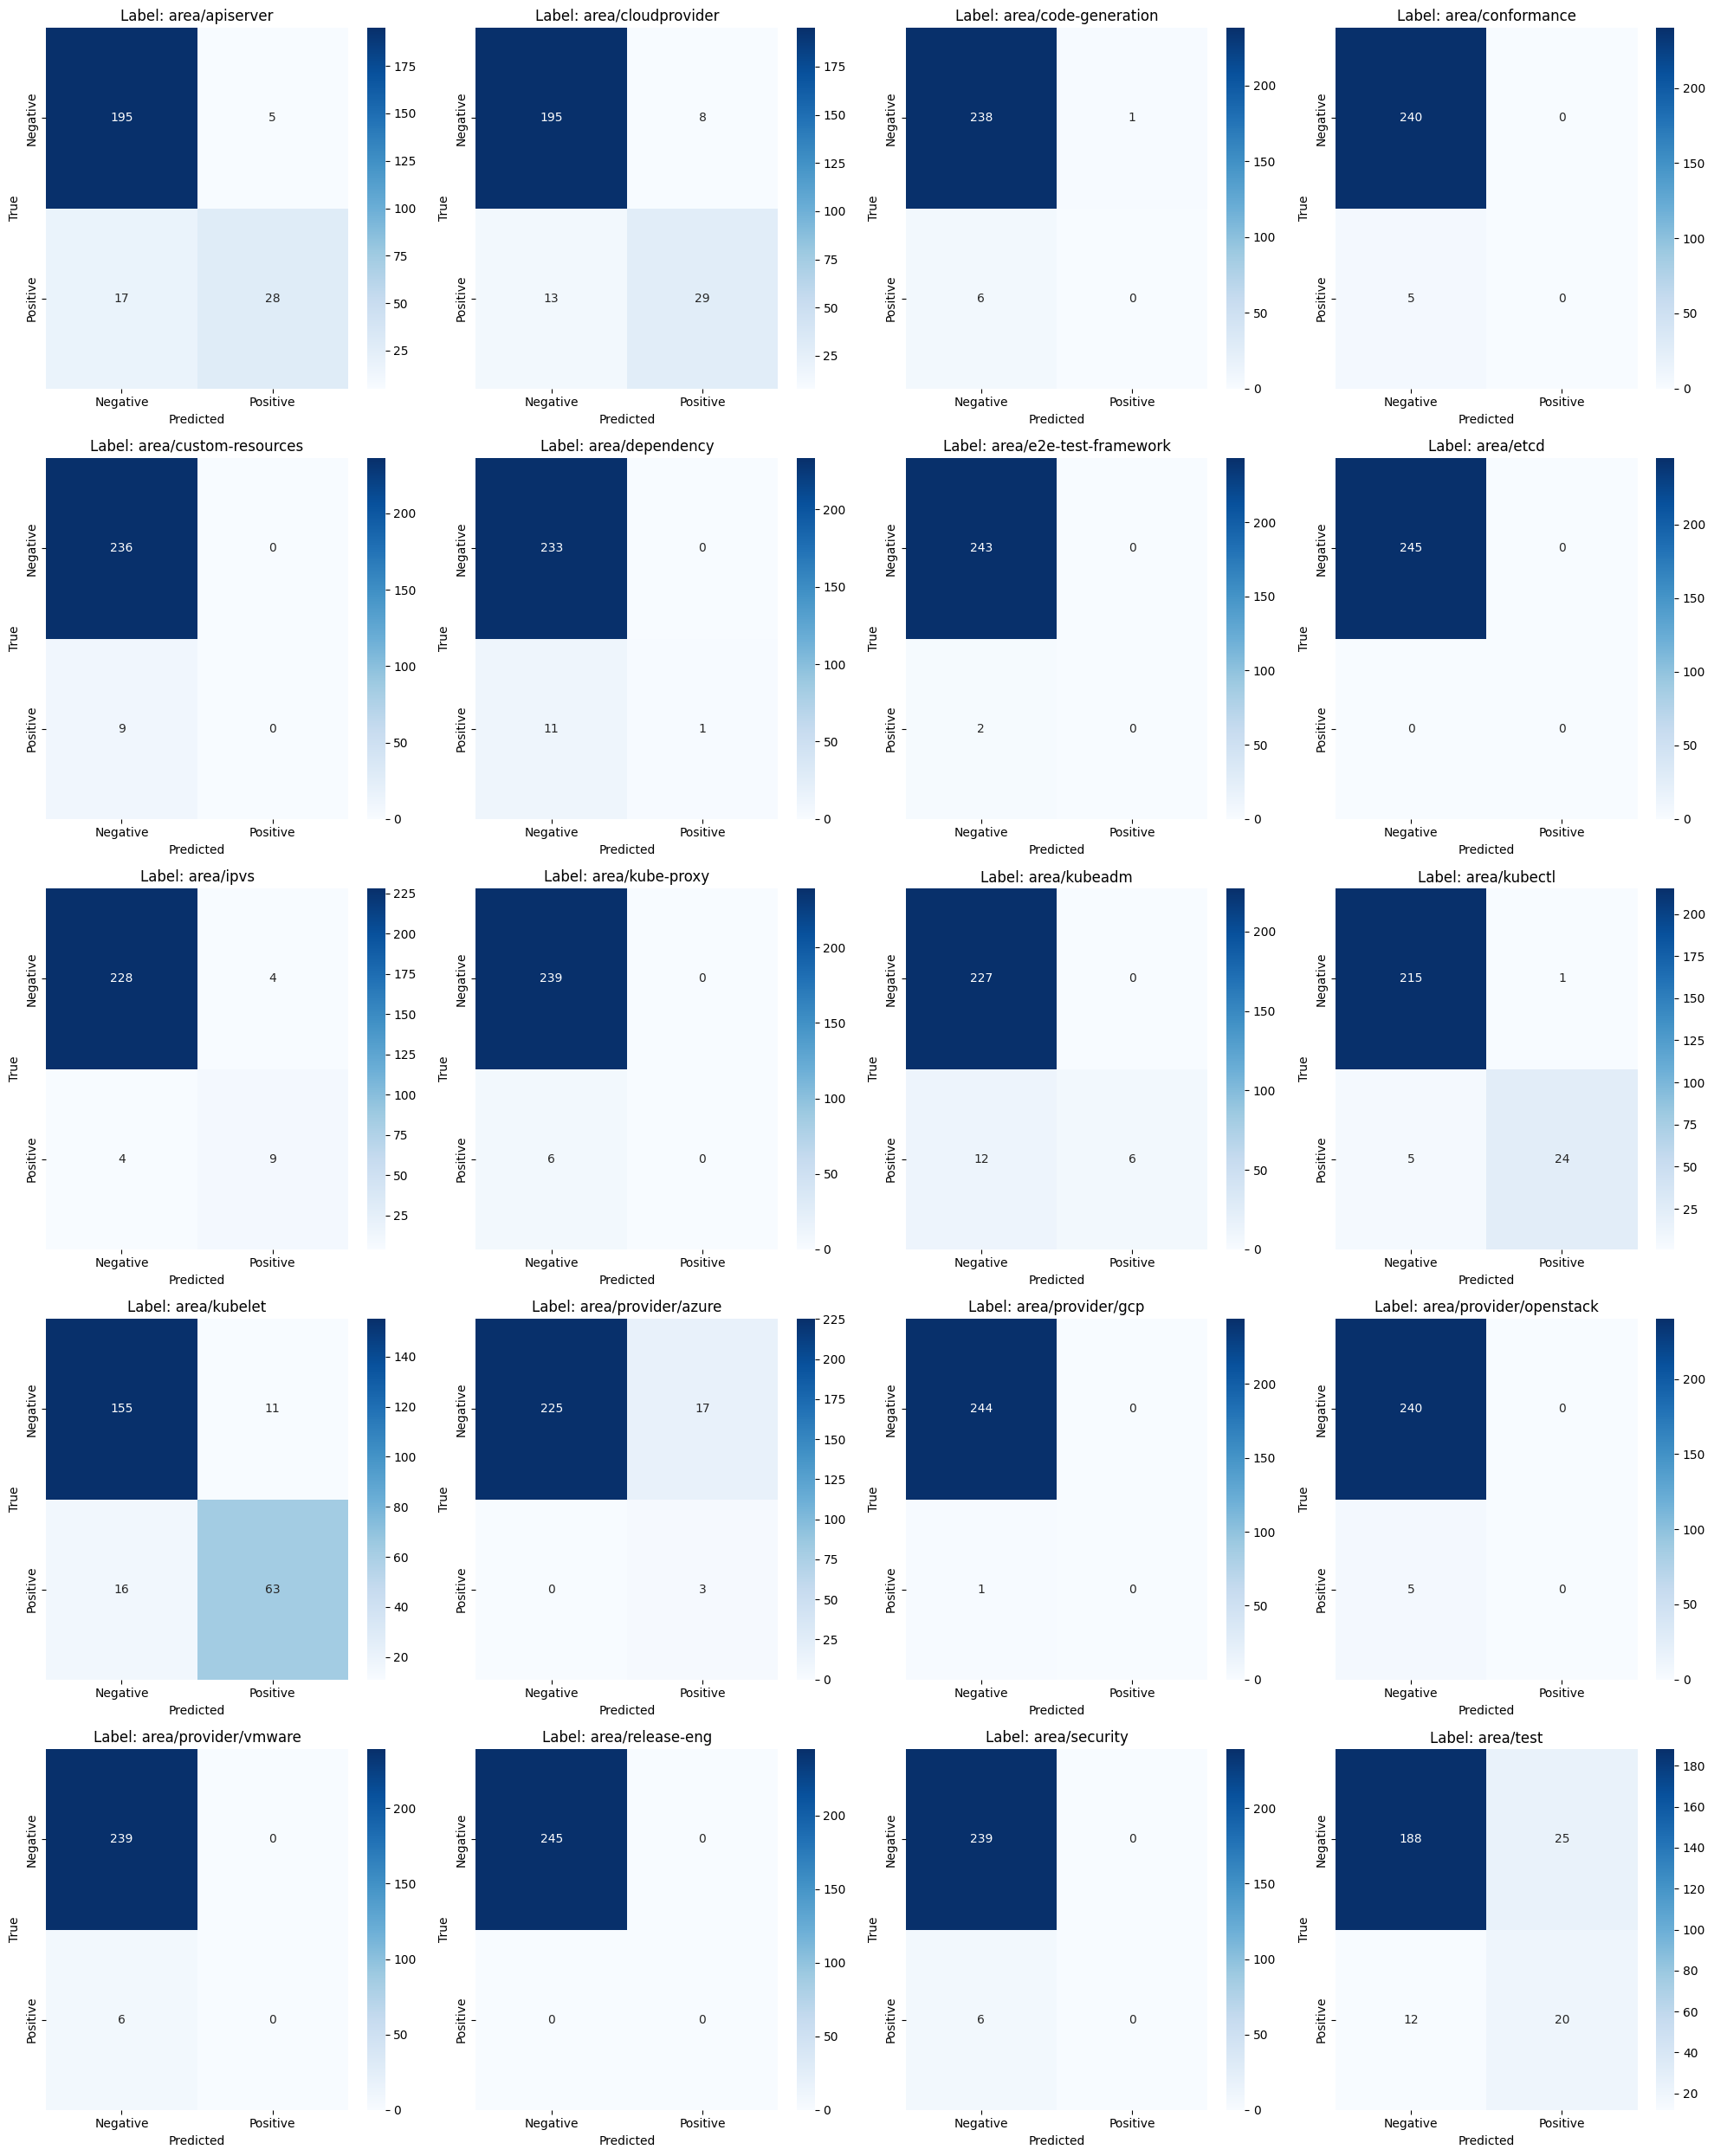

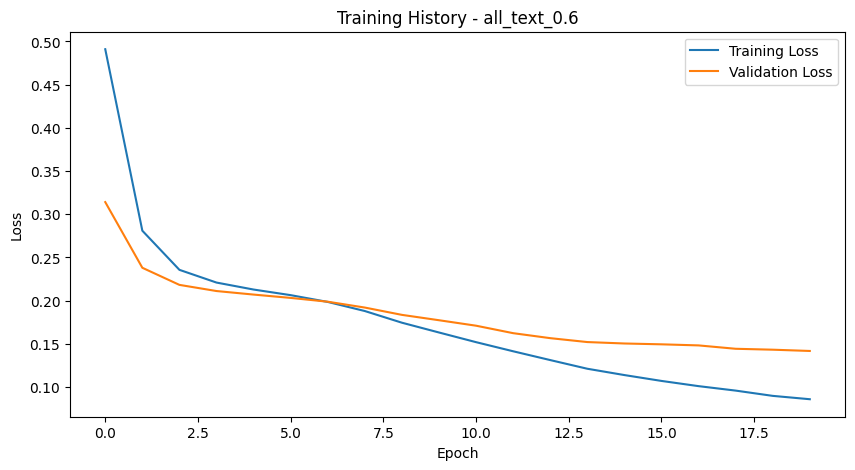

In [13]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train CodeBERT for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-bug-with-reduced-comments-0-3/cleaned_data_with_changed_files_reduced_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.6',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=0,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

## Threshold 0.7

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-bug-with-reduced-comments-0-3/cleaned_data_with_changed_files_reduced_comments.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 0 occurrences: 109
Removed 0 infrequent label combinations
Final number of samples after all filtering: 1222

 Label Distribution : 
0. area/kubelet: 372
1. area/test: 326
2. area/apiserver: 223
3. area/cloudprovider: 194
4. area/kubectl: 145
5. area/dependency: 77
6. area/provider/azure: 67
7. area/code-generation: 54
8. area/kubeadm: 47
9. area/ipvs: 47
10. area/kube-proxy: 30
11. area/provider/gcp: 29
12. area/e2e-test-framework: 23
13. area/release-eng: 18
14. area/conformance: 16
15. area/custom-resources: 16
16. area/security: 11
17. area/provider/vmware: 6
18. area/etcd: 5
19. area/provider/openstack: 5

 Label count per row distribution:
Label: 1, count: 888
Label: 2, cou

Training: 100%|██████████| 31/31 [00:33<00:00,  1.09s/it]


Train Loss: 0.4909, Train Accuracy (Exact Match): 0.0113
Val Loss: 0.3140
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Saved initial model to ./results/run_20250318_135636_all_text_0.7/best_model_all_text_0.7.pt as baseline

Epoch 2/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.2809, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2380
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.2357, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2182
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.2210, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2111
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.2130, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2071
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 6/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.2070, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2034
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 7/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1996, Train Accuracy (Exact Match): 0.0010
Val Loss: 0.1982
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0041
Val Accuracy (Jaccard): 0.0041
Val Precision: 0.0082, Val Recall: 0.0041, Val F1: 0.0053
Saved new best model to ./results/run_20250318_135636_all_text_0.7/best_model_all_text_0.7.pt

Epoch 8/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1886, Train Accuracy (Exact Match): 0.0409
Val Loss: 0.1897
Val Accuracy (Exact Match): 0.2327
Val Accuracy (Partial Match): 0.2456
Val Accuracy (Jaccard): 0.2456
Val Precision: 0.2612, Val Recall: 0.2456, Val F1: 0.2503
Saved new best model to ./results/run_20250318_135636_all_text_0.7/best_model_all_text_0.7.pt

Epoch 9/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1745, Train Accuracy (Exact Match): 0.2016
Val Loss: 0.1809
Val Accuracy (Exact Match): 0.2653
Val Accuracy (Partial Match): 0.3035
Val Accuracy (Jaccard): 0.2998
Val Precision: 0.3384, Val Recall: 0.3035, Val F1: 0.3123
Saved new best model to ./results/run_20250318_135636_all_text_0.7/best_model_all_text_0.7.pt

Epoch 10/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Train Loss: 0.1632, Train Accuracy (Exact Match): 0.2661
Val Loss: 0.1732
Val Accuracy (Exact Match): 0.2980
Val Accuracy (Partial Match): 0.3804
Val Accuracy (Jaccard): 0.3631
Val Precision: 0.4201, Val Recall: 0.3804, Val F1: 0.3865
Saved new best model to ./results/run_20250318_135636_all_text_0.7/best_model_all_text_0.7.pt

Epoch 11/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1521, Train Accuracy (Exact Match): 0.3501
Val Loss: 0.1673
Val Accuracy (Exact Match): 0.3469
Val Accuracy (Partial Match): 0.4341
Val Accuracy (Jaccard): 0.4141
Val Precision: 0.4684, Val Recall: 0.4341, Val F1: 0.4374
Saved new best model to ./results/run_20250318_135636_all_text_0.7/best_model_all_text_0.7.pt

Epoch 12/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1413, Train Accuracy (Exact Match): 0.4319
Val Loss: 0.1585
Val Accuracy (Exact Match): 0.3714
Val Accuracy (Partial Match): 0.4675
Val Accuracy (Jaccard): 0.4467
Val Precision: 0.5071, Val Recall: 0.4675, Val F1: 0.4728
Saved new best model to ./results/run_20250318_135636_all_text_0.7/best_model_all_text_0.7.pt

Epoch 13/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1316, Train Accuracy (Exact Match): 0.5087
Val Loss: 0.1535
Val Accuracy (Exact Match): 0.3918
Val Accuracy (Partial Match): 0.4962
Val Accuracy (Jaccard): 0.4734
Val Precision: 0.5418, Val Recall: 0.4962, Val F1: 0.5020
Saved new best model to ./results/run_20250318_135636_all_text_0.7/best_model_all_text_0.7.pt

Epoch 14/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1214, Train Accuracy (Exact Match): 0.5609
Val Loss: 0.1502
Val Accuracy (Exact Match): 0.4163
Val Accuracy (Partial Match): 0.5510
Val Accuracy (Jaccard): 0.5118
Val Precision: 0.5786, Val Recall: 0.5510, Val F1: 0.5457
Saved new best model to ./results/run_20250318_135636_all_text_0.7/best_model_all_text_0.7.pt

Epoch 15/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1147, Train Accuracy (Exact Match): 0.5732
Val Loss: 0.1470
Val Accuracy (Exact Match): 0.4163
Val Accuracy (Partial Match): 0.5244
Val Accuracy (Jaccard): 0.4993
Val Precision: 0.5704, Val Recall: 0.5244, Val F1: 0.5298

Epoch 16/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1079, Train Accuracy (Exact Match): 0.5937
Val Loss: 0.1455
Val Accuracy (Exact Match): 0.4367
Val Accuracy (Partial Match): 0.5496
Val Accuracy (Jaccard): 0.5203
Val Precision: 0.5908, Val Recall: 0.5496, Val F1: 0.5517
Saved new best model to ./results/run_20250318_135636_all_text_0.7/best_model_all_text_0.7.pt

Epoch 17/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1024, Train Accuracy (Exact Match): 0.6131
Val Loss: 0.1459
Val Accuracy (Exact Match): 0.4367
Val Accuracy (Partial Match): 0.5591
Val Accuracy (Jaccard): 0.5254
Val Precision: 0.5990, Val Recall: 0.5591, Val F1: 0.5582
Saved new best model to ./results/run_20250318_135636_all_text_0.7/best_model_all_text_0.7.pt

Epoch 18/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.0969, Train Accuracy (Exact Match): 0.6305
Val Loss: 0.1411
Val Accuracy (Exact Match): 0.4490
Val Accuracy (Partial Match): 0.5843
Val Accuracy (Jaccard): 0.5428
Val Precision: 0.6112, Val Recall: 0.5843, Val F1: 0.5775
Saved new best model to ./results/run_20250318_135636_all_text_0.7/best_model_all_text_0.7.pt

Epoch 19/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.0912, Train Accuracy (Exact Match): 0.6407
Val Loss: 0.1414
Val Accuracy (Exact Match): 0.4571
Val Accuracy (Partial Match): 0.5848
Val Accuracy (Jaccard): 0.5478
Val Precision: 0.6173, Val Recall: 0.5848, Val F1: 0.5813
Saved new best model to ./results/run_20250318_135636_all_text_0.7/best_model_all_text_0.7.pt

Epoch 20/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Train Loss: 0.0870, Train Accuracy (Exact Match): 0.6489
Val Loss: 0.1400
Val Accuracy (Exact Match): 0.4612
Val Accuracy (Partial Match): 0.6176
Val Accuracy (Jaccard): 0.5673
Val Precision: 0.6392, Val Recall: 0.6176, Val F1: 0.6062
Saved new best model to ./results/run_20250318_135636_all_text_0.7/best_model_all_text_0.7.pt

Loading best model for final evaluation...


<ipython-input-11-1606e2bcbdc8>:224: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.4612
Partial Match Accuracy: 0.6176
Jaccard Similarity: 0.5673
Precision: 0.6392
Recall: 0.6176
F1 Score: 0.6062

Training completed! Results saved to ./results/run_20250318_135636_all_text_0.7


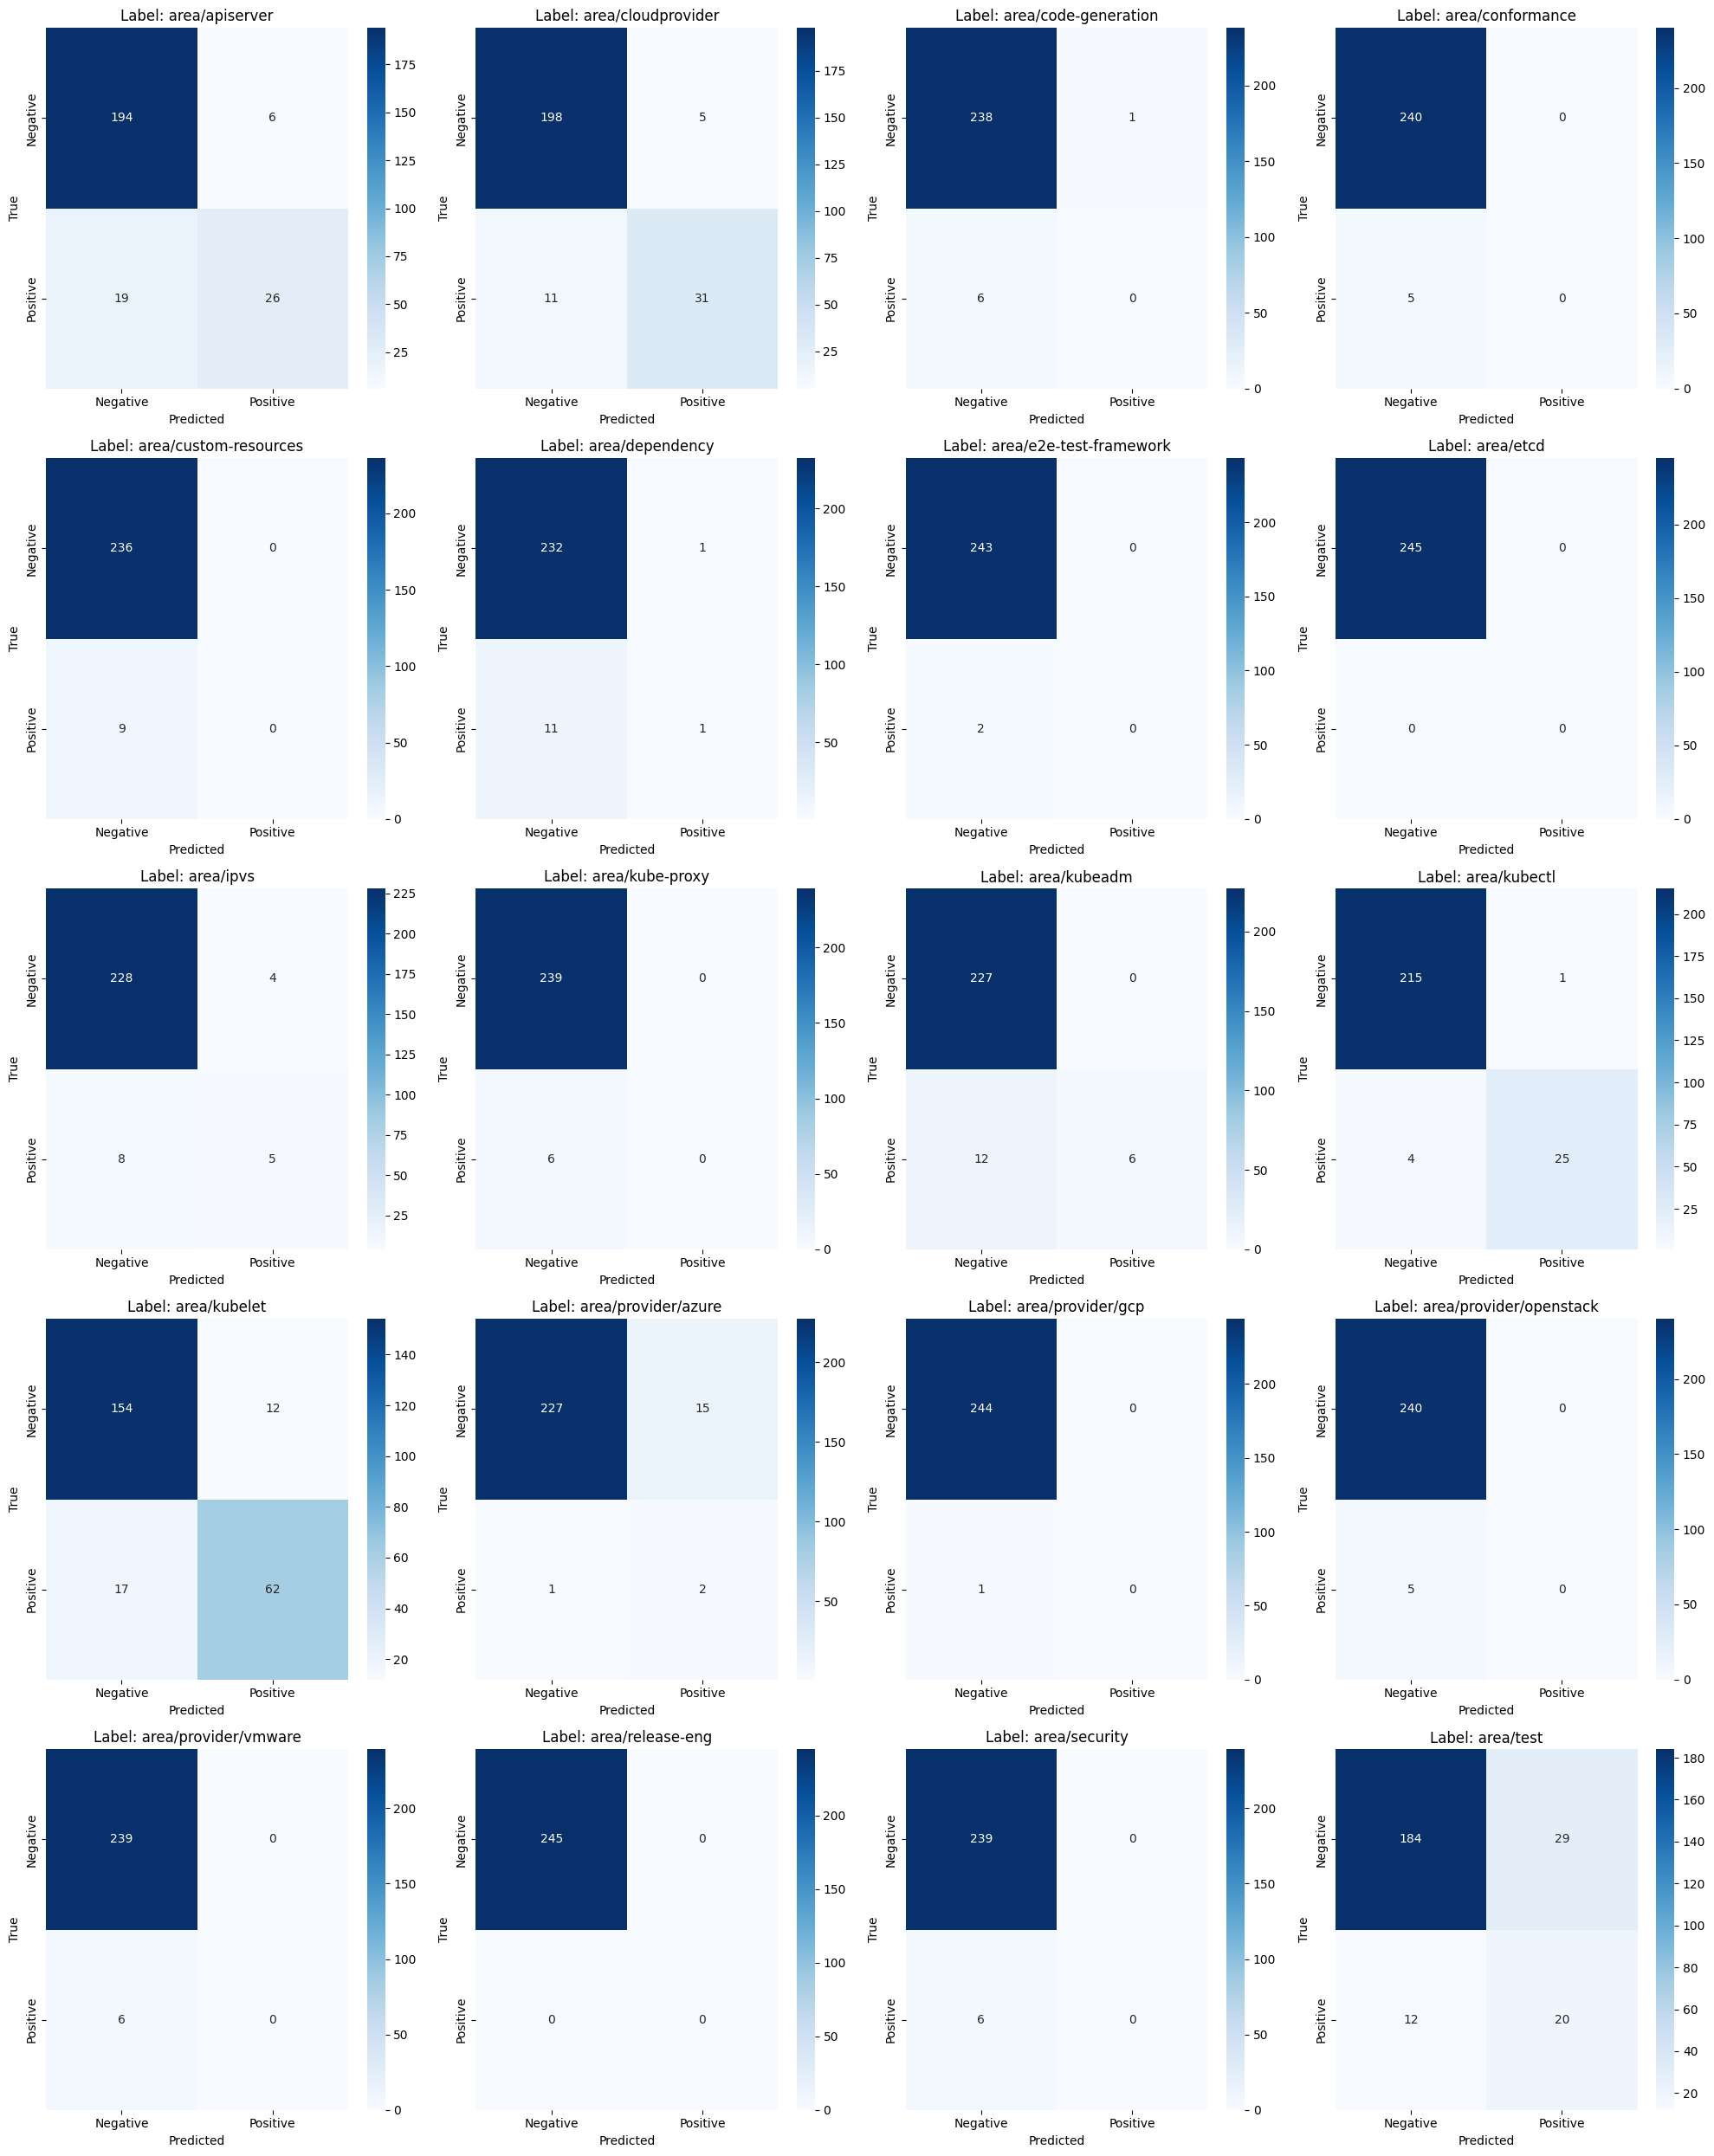

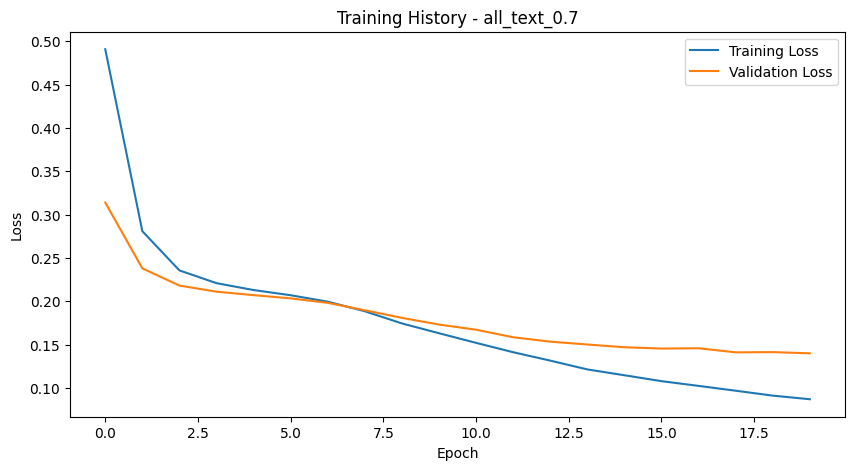

In [14]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train CodeBERT for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-bug-with-reduced-comments-0-3/cleaned_data_with_changed_files_reduced_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.7',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=0,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

## Threshold 0.8

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-bug-with-reduced-comments-0-3/cleaned_data_with_changed_files_reduced_comments.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 0 occurrences: 109
Removed 0 infrequent label combinations
Final number of samples after all filtering: 1222

 Label Distribution : 
0. area/kubelet: 372
1. area/test: 326
2. area/apiserver: 223
3. area/cloudprovider: 194
4. area/kubectl: 145
5. area/dependency: 77
6. area/provider/azure: 67
7. area/code-generation: 54
8. area/kubeadm: 47
9. area/ipvs: 47
10. area/kube-proxy: 30
11. area/provider/gcp: 29
12. area/e2e-test-framework: 23
13. area/release-eng: 18
14. area/conformance: 16
15. area/custom-resources: 16
16. area/security: 11
17. area/provider/vmware: 6
18. area/etcd: 5
19. area/provider/openstack: 5

 Label count per row distribution:
Label: 1, count: 888
Label: 2, cou

Training: 100%|██████████| 31/31 [00:33<00:00,  1.09s/it]


Train Loss: 0.4907, Train Accuracy (Exact Match): 0.0123
Val Loss: 0.3140
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Saved initial model to ./results/run_20250318_141000_all_text_0.8/best_model_all_text_0.8.pt as baseline

Epoch 2/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Train Loss: 0.2809, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2380
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.2357, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2182
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.2210, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2112
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]


Train Loss: 0.2131, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2072
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 6/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.2073, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2036
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 7/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.2003, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.1987
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0054
Val Accuracy (Jaccard): 0.0054
Val Precision: 0.0082, Val Recall: 0.0054, Val F1: 0.0065
Saved new best model to ./results/run_20250318_141000_all_text_0.8/best_model_all_text_0.8.pt

Epoch 8/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1892, Train Accuracy (Exact Match): 0.0328
Val Loss: 0.1900
Val Accuracy (Exact Match): 0.2327
Val Accuracy (Partial Match): 0.2490
Val Accuracy (Jaccard): 0.2490
Val Precision: 0.2694, Val Recall: 0.2490, Val F1: 0.2551
Saved new best model to ./results/run_20250318_141000_all_text_0.8/best_model_all_text_0.8.pt

Epoch 9/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1753, Train Accuracy (Exact Match): 0.2006
Val Loss: 0.1803
Val Accuracy (Exact Match): 0.2694
Val Accuracy (Partial Match): 0.3022
Val Accuracy (Jaccard): 0.3015
Val Precision: 0.3415, Val Recall: 0.3022, Val F1: 0.3135
Saved new best model to ./results/run_20250318_141000_all_text_0.8/best_model_all_text_0.8.pt

Epoch 10/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Train Loss: 0.1634, Train Accuracy (Exact Match): 0.2671
Val Loss: 0.1732
Val Accuracy (Exact Match): 0.2735
Val Accuracy (Partial Match): 0.3546
Val Accuracy (Jaccard): 0.3365
Val Precision: 0.3888, Val Recall: 0.3546, Val F1: 0.3585
Saved new best model to ./results/run_20250318_141000_all_text_0.8/best_model_all_text_0.8.pt

Epoch 11/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Train Loss: 0.1530, Train Accuracy (Exact Match): 0.3470
Val Loss: 0.1673
Val Accuracy (Exact Match): 0.3388
Val Accuracy (Partial Match): 0.4260
Val Accuracy (Jaccard): 0.4039
Val Precision: 0.4541, Val Recall: 0.4260, Val F1: 0.4265
Saved new best model to ./results/run_20250318_141000_all_text_0.8/best_model_all_text_0.8.pt

Epoch 12/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1421, Train Accuracy (Exact Match): 0.4371
Val Loss: 0.1592
Val Accuracy (Exact Match): 0.3755
Val Accuracy (Partial Match): 0.4797
Val Accuracy (Jaccard): 0.4536
Val Precision: 0.5133, Val Recall: 0.4797, Val F1: 0.4813
Saved new best model to ./results/run_20250318_141000_all_text_0.8/best_model_all_text_0.8.pt

Epoch 13/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1323, Train Accuracy (Exact Match): 0.5046
Val Loss: 0.1537
Val Accuracy (Exact Match): 0.4041
Val Accuracy (Partial Match): 0.5074
Val Accuracy (Jaccard): 0.4846
Val Precision: 0.5541, Val Recall: 0.5074, Val F1: 0.5132
Saved new best model to ./results/run_20250318_141000_all_text_0.8/best_model_all_text_0.8.pt

Epoch 14/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1220, Train Accuracy (Exact Match): 0.5455
Val Loss: 0.1503
Val Accuracy (Exact Match): 0.4122
Val Accuracy (Partial Match): 0.5448
Val Accuracy (Jaccard): 0.5091
Val Precision: 0.5806, Val Recall: 0.5448, Val F1: 0.5430
Saved new best model to ./results/run_20250318_141000_all_text_0.8/best_model_all_text_0.8.pt

Epoch 15/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1158, Train Accuracy (Exact Match): 0.5742
Val Loss: 0.1471
Val Accuracy (Exact Match): 0.4204
Val Accuracy (Partial Match): 0.5251
Val Accuracy (Jaccard): 0.5016
Val Precision: 0.5724, Val Recall: 0.5251, Val F1: 0.5308

Epoch 16/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1085, Train Accuracy (Exact Match): 0.5803
Val Loss: 0.1463
Val Accuracy (Exact Match): 0.4286
Val Accuracy (Partial Match): 0.5399
Val Accuracy (Jaccard): 0.5127
Val Precision: 0.5806, Val Recall: 0.5399, Val F1: 0.5434
Saved new best model to ./results/run_20250318_141000_all_text_0.8/best_model_all_text_0.8.pt

Epoch 17/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1030, Train Accuracy (Exact Match): 0.6100
Val Loss: 0.1474
Val Accuracy (Exact Match): 0.4204
Val Accuracy (Partial Match): 0.5161
Val Accuracy (Jaccard): 0.4930
Val Precision: 0.5561, Val Recall: 0.5161, Val F1: 0.5197

Epoch 18/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.0976, Train Accuracy (Exact Match): 0.6244
Val Loss: 0.1414
Val Accuracy (Exact Match): 0.4571
Val Accuracy (Partial Match): 0.5950
Val Accuracy (Jaccard): 0.5552
Val Precision: 0.6214, Val Recall: 0.5950, Val F1: 0.5899
Saved new best model to ./results/run_20250318_141000_all_text_0.8/best_model_all_text_0.8.pt

Epoch 19/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.0911, Train Accuracy (Exact Match): 0.6346
Val Loss: 0.1432
Val Accuracy (Exact Match): 0.4653
Val Accuracy (Partial Match): 0.5719
Val Accuracy (Jaccard): 0.5444
Val Precision: 0.6092, Val Recall: 0.5719, Val F1: 0.5732

Epoch 20/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Train Loss: 0.0877, Train Accuracy (Exact Match): 0.6592
Val Loss: 0.1401
Val Accuracy (Exact Match): 0.4735
Val Accuracy (Partial Match): 0.6182
Val Accuracy (Jaccard): 0.5754
Val Precision: 0.6453, Val Recall: 0.6182, Val F1: 0.6122
Saved new best model to ./results/run_20250318_141000_all_text_0.8/best_model_all_text_0.8.pt

Loading best model for final evaluation...


<ipython-input-11-1606e2bcbdc8>:224: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.4735
Partial Match Accuracy: 0.6182
Jaccard Similarity: 0.5754
Precision: 0.6453
Recall: 0.6182
F1 Score: 0.6122

Training completed! Results saved to ./results/run_20250318_141000_all_text_0.8


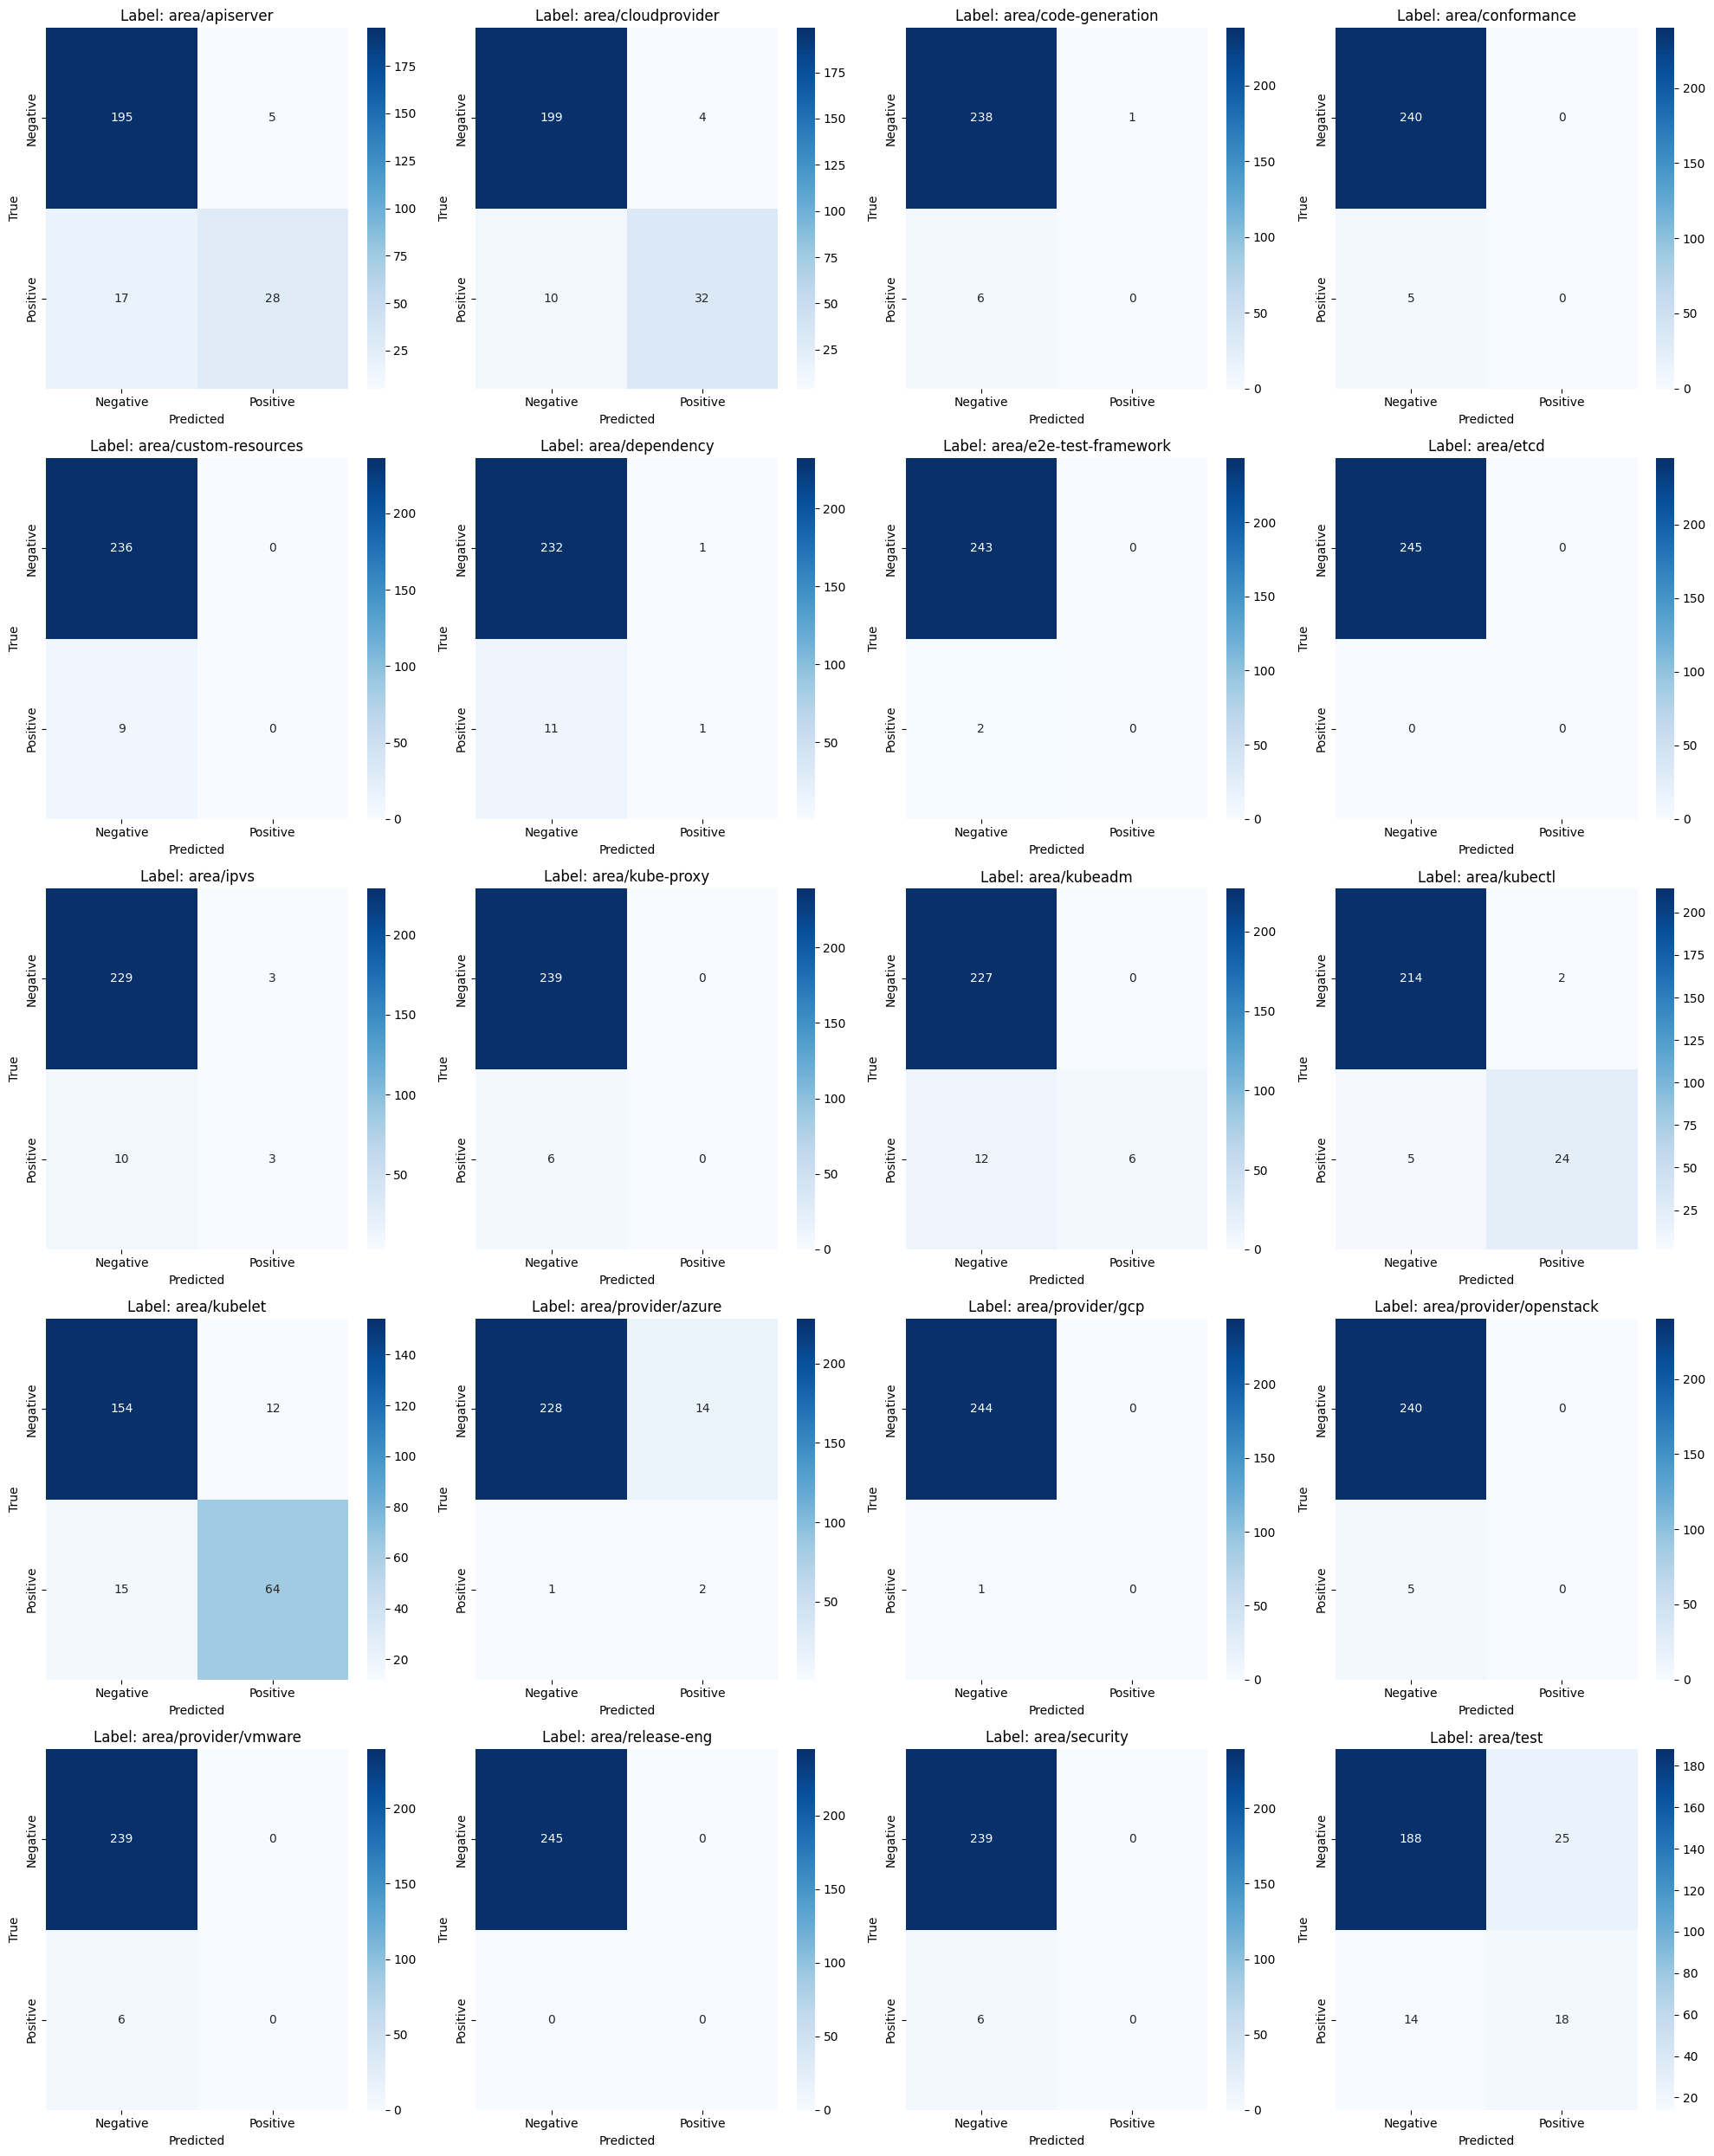

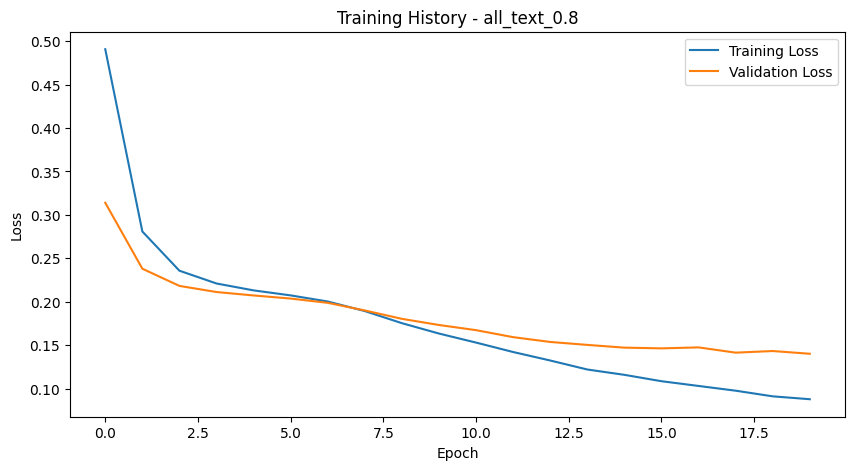

In [15]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train CodeBERT for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-bug-with-reduced-comments-0-3/cleaned_data_with_changed_files_reduced_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.8',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=0,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

## Threshold 0.9

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-bug-with-reduced-comments-0-3/cleaned_data_with_changed_files_reduced_comments.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 0 occurrences: 109
Removed 0 infrequent label combinations
Final number of samples after all filtering: 1222

 Label Distribution : 
0. area/kubelet: 372
1. area/test: 326
2. area/apiserver: 223
3. area/cloudprovider: 194
4. area/kubectl: 145
5. area/dependency: 77
6. area/provider/azure: 67
7. area/code-generation: 54
8. area/kubeadm: 47
9. area/ipvs: 47
10. area/kube-proxy: 30
11. area/provider/gcp: 29
12. area/e2e-test-framework: 23
13. area/release-eng: 18
14. area/conformance: 16
15. area/custom-resources: 16
16. area/security: 11
17. area/provider/vmware: 6
18. area/etcd: 5
19. area/provider/openstack: 5

 Label count per row distribution:
Label: 1, count: 888
Label: 2, cou

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

Using larger batch size of 32 for 2 GPUs
Initializing model...


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Model wrapped in DataParallel
Starting training for 20 epochs...

Epoch 1/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]


Train Loss: 0.4908, Train Accuracy (Exact Match): 0.0123
Val Loss: 0.3141
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Saved initial model to ./results/run_20250318_155855_all_text_0.9/best_model_all_text_0.9.pt as baseline

Epoch 2/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]


Train Loss: 0.2809, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2381
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 31/31 [00:33<00:00,  1.08s/it]


Train Loss: 0.2358, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2183
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.04s/it]


Train Loss: 0.2211, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2113
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 31/31 [00:33<00:00,  1.07s/it]


Train Loss: 0.2133, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2074
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 6/20


Training: 100%|██████████| 31/31 [00:33<00:00,  1.07s/it]


Train Loss: 0.2079, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2042
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 7/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Train Loss: 0.2017, Train Accuracy (Exact Match): 0.0010
Val Loss: 0.1996
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0027
Val Accuracy (Jaccard): 0.0027
Val Precision: 0.0082, Val Recall: 0.0027, Val F1: 0.0041
Saved new best model to ./results/run_20250318_155855_all_text_0.9/best_model_all_text_0.9.pt

Epoch 8/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Train Loss: 0.1912, Train Accuracy (Exact Match): 0.0246
Val Loss: 0.1923
Val Accuracy (Exact Match): 0.2082
Val Accuracy (Partial Match): 0.2185
Val Accuracy (Jaccard): 0.2185
Val Precision: 0.2327, Val Recall: 0.2185, Val F1: 0.2224
Saved new best model to ./results/run_20250318_155855_all_text_0.9/best_model_all_text_0.9.pt

Epoch 9/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Train Loss: 0.1781, Train Accuracy (Exact Match): 0.1842
Val Loss: 0.1826
Val Accuracy (Exact Match): 0.2694
Val Accuracy (Partial Match): 0.3022
Val Accuracy (Jaccard): 0.3015
Val Precision: 0.3415, Val Recall: 0.3022, Val F1: 0.3135
Saved new best model to ./results/run_20250318_155855_all_text_0.9/best_model_all_text_0.9.pt

Epoch 10/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Train Loss: 0.1663, Train Accuracy (Exact Match): 0.2487
Val Loss: 0.1753
Val Accuracy (Exact Match): 0.2735
Val Accuracy (Partial Match): 0.3396
Val Accuracy (Jaccard): 0.3284
Val Precision: 0.3806, Val Recall: 0.3396, Val F1: 0.3476
Saved new best model to ./results/run_20250318_155855_all_text_0.9/best_model_all_text_0.9.pt

Epoch 11/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Train Loss: 0.1557, Train Accuracy (Exact Match): 0.3193
Val Loss: 0.1689
Val Accuracy (Exact Match): 0.3143
Val Accuracy (Partial Match): 0.4056
Val Accuracy (Jaccard): 0.3807
Val Precision: 0.4296, Val Recall: 0.4056, Val F1: 0.4040
Saved new best model to ./results/run_20250318_155855_all_text_0.9/best_model_all_text_0.9.pt

Epoch 12/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Train Loss: 0.1452, Train Accuracy (Exact Match): 0.3992
Val Loss: 0.1604
Val Accuracy (Exact Match): 0.3469
Val Accuracy (Partial Match): 0.4559
Val Accuracy (Jaccard): 0.4284
Val Precision: 0.4867, Val Recall: 0.4559, Val F1: 0.4563
Saved new best model to ./results/run_20250318_155855_all_text_0.9/best_model_all_text_0.9.pt

Epoch 13/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Train Loss: 0.1351, Train Accuracy (Exact Match): 0.4872
Val Loss: 0.1552
Val Accuracy (Exact Match): 0.3755
Val Accuracy (Partial Match): 0.4751
Val Accuracy (Jaccard): 0.4523
Val Precision: 0.5133, Val Recall: 0.4751, Val F1: 0.4787
Saved new best model to ./results/run_20250318_155855_all_text_0.9/best_model_all_text_0.9.pt

Epoch 14/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Train Loss: 0.1249, Train Accuracy (Exact Match): 0.5302
Val Loss: 0.1516
Val Accuracy (Exact Match): 0.3918
Val Accuracy (Partial Match): 0.5210
Val Accuracy (Jaccard): 0.4826
Val Precision: 0.5439, Val Recall: 0.5210, Val F1: 0.5151
Saved new best model to ./results/run_20250318_155855_all_text_0.9/best_model_all_text_0.9.pt

Epoch 15/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.1181, Train Accuracy (Exact Match): 0.5629
Val Loss: 0.1481
Val Accuracy (Exact Match): 0.4163
Val Accuracy (Partial Match): 0.5190
Val Accuracy (Jaccard): 0.4945
Val Precision: 0.5602, Val Recall: 0.5190, Val F1: 0.5230
Saved new best model to ./results/run_20250318_155855_all_text_0.9/best_model_all_text_0.9.pt

Epoch 16/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Train Loss: 0.1112, Train Accuracy (Exact Match): 0.5916
Val Loss: 0.1469
Val Accuracy (Exact Match): 0.4490
Val Accuracy (Partial Match): 0.5686
Val Accuracy (Jaccard): 0.5380
Val Precision: 0.6071, Val Recall: 0.5686, Val F1: 0.5698
Saved new best model to ./results/run_20250318_155855_all_text_0.9/best_model_all_text_0.9.pt

Epoch 17/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.06s/it]


Train Loss: 0.1054, Train Accuracy (Exact Match): 0.6039
Val Loss: 0.1480
Val Accuracy (Exact Match): 0.4204
Val Accuracy (Partial Match): 0.5393
Val Accuracy (Jaccard): 0.5052
Val Precision: 0.5684, Val Recall: 0.5393, Val F1: 0.5360

Epoch 18/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.0993, Train Accuracy (Exact Match): 0.6213
Val Loss: 0.1421
Val Accuracy (Exact Match): 0.4449
Val Accuracy (Partial Match): 0.5829
Val Accuracy (Jaccard): 0.5418
Val Precision: 0.6092, Val Recall: 0.5829, Val F1: 0.5764
Saved new best model to ./results/run_20250318_155855_all_text_0.9/best_model_all_text_0.9.pt

Epoch 19/20


Training: 100%|██████████| 31/31 [00:33<00:00,  1.07s/it]


Train Loss: 0.0945, Train Accuracy (Exact Match): 0.6397
Val Loss: 0.1446
Val Accuracy (Exact Match): 0.4571
Val Accuracy (Partial Match): 0.5835
Val Accuracy (Jaccard): 0.5467
Val Precision: 0.6133, Val Recall: 0.5835, Val F1: 0.5796
Saved new best model to ./results/run_20250318_155855_all_text_0.9/best_model_all_text_0.9.pt

Epoch 20/20


Training: 100%|██████████| 31/31 [00:32<00:00,  1.05s/it]


Train Loss: 0.0896, Train Accuracy (Exact Match): 0.6428
Val Loss: 0.1417
Val Accuracy (Exact Match): 0.4531
Val Accuracy (Partial Match): 0.6074
Val Accuracy (Jaccard): 0.5550
Val Precision: 0.6184, Val Recall: 0.6074, Val F1: 0.5917
Saved new best model to ./results/run_20250318_155855_all_text_0.9/best_model_all_text_0.9.pt

Loading best model for final evaluation...


<ipython-input-11-1606e2bcbdc8>:224: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.4531
Partial Match Accuracy: 0.6074
Jaccard Similarity: 0.5550
Precision: 0.6184
Recall: 0.6074
F1 Score: 0.5917

Training completed! Results saved to ./results/run_20250318_155855_all_text_0.9


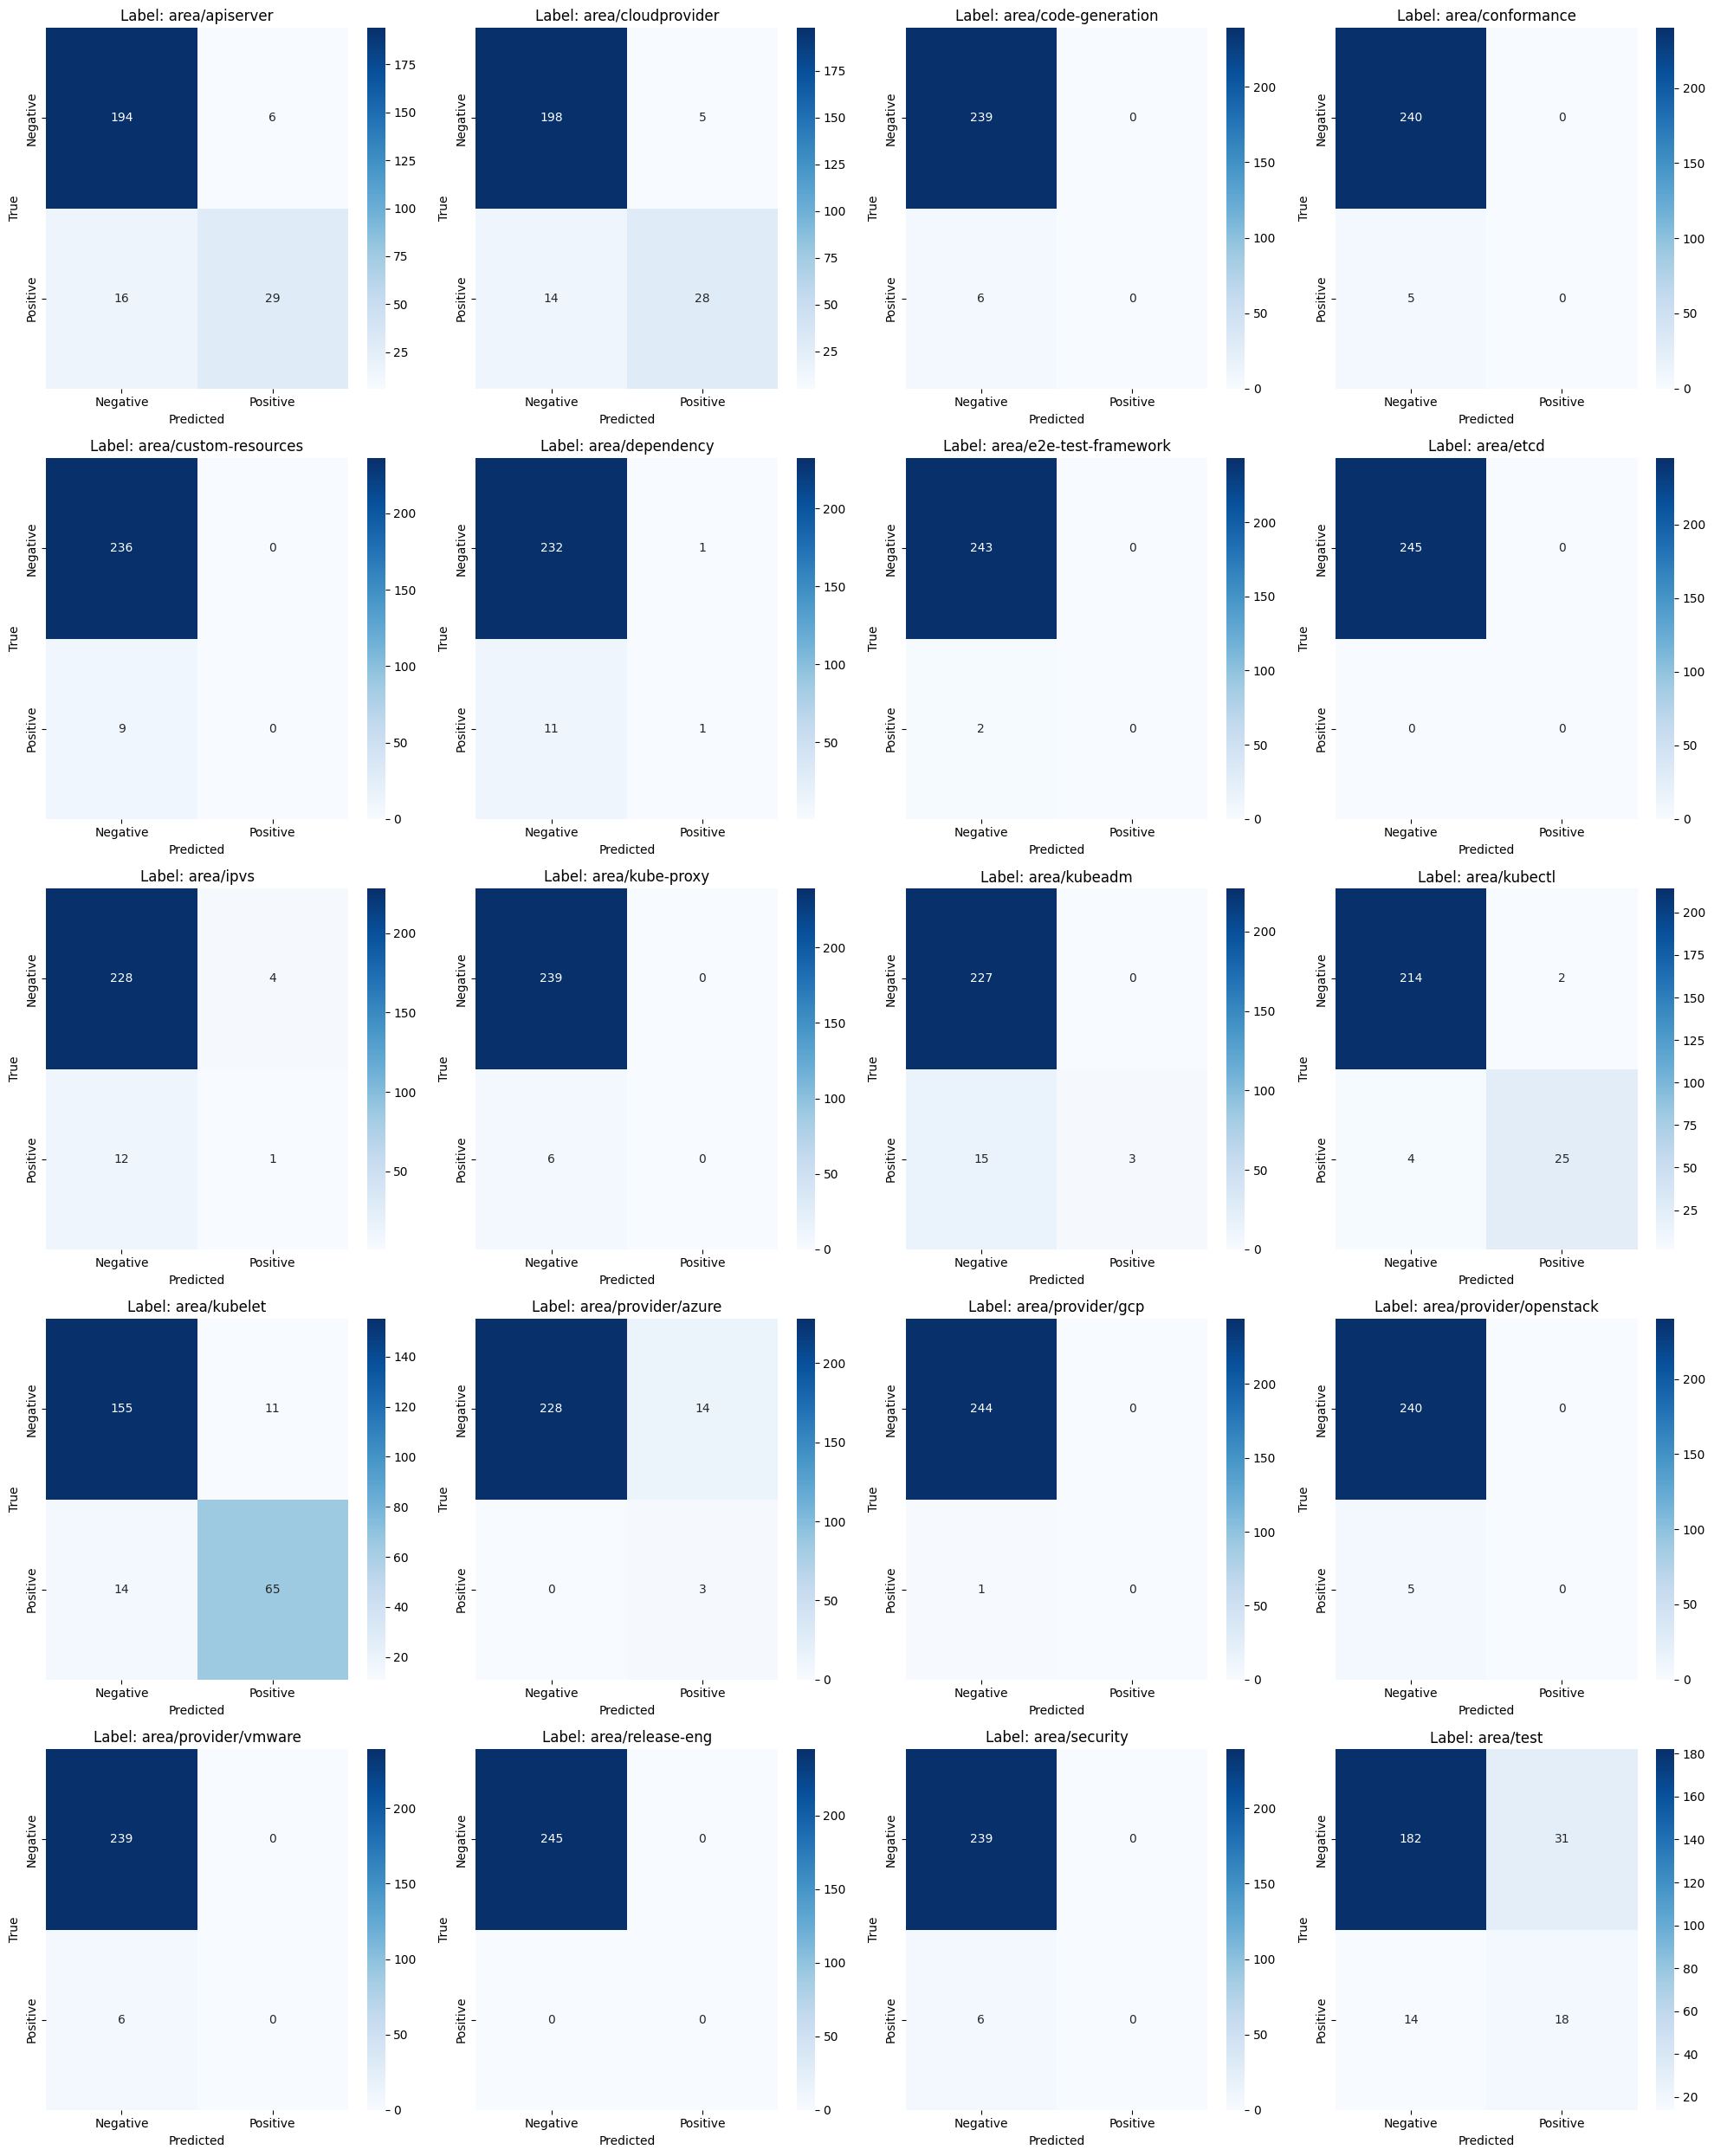

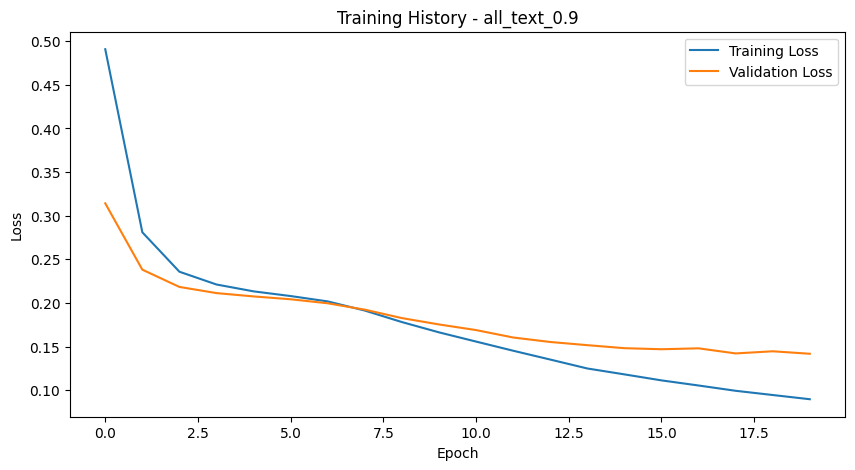

In [12]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train CodeBERT for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-bug-with-reduced-comments-0-3/cleaned_data_with_changed_files_reduced_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.9',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=0,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

# Use All Text

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-bug-with-reduced-comments-0-3/cleaned_data_with_changed_files_reduced_comments.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 0 occurrences: 109
Removed 0 infrequent label combinations
Final number of samples after all filtering: 1222

 Label Distribution : 
0. area/kubelet: 372
1. area/test: 326
2. area/apiserver: 223
3. area/cloudprovider: 194
4. area/kubectl: 145
5. area/dependency: 77
6. area/provider/azure: 67
7. area/code-generation: 54
8. area/kubeadm: 47
9. area/ipvs: 47
10. area/kube-proxy: 30
11. area/provider/gcp: 29
12. area/e2e-test-framework: 23
13. area/release-eng: 18
14. area/conformance: 16
15. area/custom-resources: 16
16. area/security: 11
17. area/provider/vmware: 6
18. area/etcd: 5
19. area/provider/openstack: 5

 Label count per row distribution:
Label: 1, count: 888
Label: 2, cou

Training: 100%|██████████| 31/31 [00:39<00:00,  1.29s/it]


Train Loss: 0.4895, Train Accuracy (Exact Match): 0.0133
Val Loss: 0.3140
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Saved initial model to ./results/run_20250318_162723_all_text/best_model_all_text.pt as baseline

Epoch 2/20


Training: 100%|██████████| 31/31 [00:36<00:00,  1.19s/it]


Train Loss: 0.2813, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2378
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


Train Loss: 0.2359, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2186
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


Train Loss: 0.2215, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2117
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


Train Loss: 0.2141, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2085
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 6/20


Training: 100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


Train Loss: 0.2101, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2073
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 7/20


Training: 100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


Train Loss: 0.2090, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2068
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 8/20


Training: 100%|██████████| 31/31 [00:37<00:00,  1.20s/it]


Train Loss: 0.2069, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2059
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 9/20


Training: 100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


Train Loss: 0.2044, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2051
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 10/20


Training: 100%|██████████| 31/31 [00:37<00:00,  1.20s/it]


Train Loss: 0.2016, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2009
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 11/20


Training: 100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


Train Loss: 0.1917, Train Accuracy (Exact Match): 0.0266
Val Loss: 0.1898
Val Accuracy (Exact Match): 0.1347
Val Accuracy (Partial Match): 0.1620
Val Accuracy (Jaccard): 0.1539
Val Precision: 0.1714, Val Recall: 0.1620, Val F1: 0.1612
Saved new best model to ./results/run_20250318_162723_all_text/best_model_all_text.pt

Epoch 12/20


Training: 100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


Train Loss: 0.1771, Train Accuracy (Exact Match): 0.1832
Val Loss: 0.1825
Val Accuracy (Exact Match): 0.2122
Val Accuracy (Partial Match): 0.2750
Val Accuracy (Jaccard): 0.2535
Val Precision: 0.2816, Val Recall: 0.2750, Val F1: 0.2690
Saved new best model to ./results/run_20250318_162723_all_text/best_model_all_text.pt

Epoch 13/20


Training: 100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


Train Loss: 0.1662, Train Accuracy (Exact Match): 0.2641
Val Loss: 0.1757
Val Accuracy (Exact Match): 0.2531
Val Accuracy (Partial Match): 0.3280
Val Accuracy (Jaccard): 0.3005
Val Precision: 0.3286, Val Recall: 0.3280, Val F1: 0.3180
Saved new best model to ./results/run_20250318_162723_all_text/best_model_all_text.pt

Epoch 14/20


Training: 100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


Train Loss: 0.1565, Train Accuracy (Exact Match): 0.3163
Val Loss: 0.1712
Val Accuracy (Exact Match): 0.2939
Val Accuracy (Partial Match): 0.3818
Val Accuracy (Jaccard): 0.3535
Val Precision: 0.3959, Val Recall: 0.3818, Val F1: 0.3758
Saved new best model to ./results/run_20250318_162723_all_text/best_model_all_text.pt

Epoch 15/20


Training: 100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


Train Loss: 0.1497, Train Accuracy (Exact Match): 0.4033
Val Loss: 0.1664
Val Accuracy (Exact Match): 0.3469
Val Accuracy (Partial Match): 0.4284
Val Accuracy (Jaccard): 0.4063
Val Precision: 0.4510, Val Recall: 0.4284, Val F1: 0.4275
Saved new best model to ./results/run_20250318_162723_all_text/best_model_all_text.pt

Epoch 16/20


Training: 100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


Train Loss: 0.1422, Train Accuracy (Exact Match): 0.4483
Val Loss: 0.1644
Val Accuracy (Exact Match): 0.3429
Val Accuracy (Partial Match): 0.4222
Val Accuracy (Jaccard): 0.3995
Val Precision: 0.4408, Val Recall: 0.4222, Val F1: 0.4200

Epoch 17/20


Training: 100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


Train Loss: 0.1353, Train Accuracy (Exact Match): 0.4759
Val Loss: 0.1645
Val Accuracy (Exact Match): 0.2980
Val Accuracy (Partial Match): 0.3896
Val Accuracy (Jaccard): 0.3614
Val Precision: 0.4082, Val Recall: 0.3896, Val F1: 0.3848

Epoch 18/20


Training: 100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


Train Loss: 0.1275, Train Accuracy (Exact Match): 0.5107
Val Loss: 0.1595
Val Accuracy (Exact Match): 0.3510
Val Accuracy (Partial Match): 0.4680
Val Accuracy (Jaccard): 0.4336
Val Precision: 0.4959, Val Recall: 0.4680, Val F1: 0.4635
Saved new best model to ./results/run_20250318_162723_all_text/best_model_all_text.pt

Epoch 19/20


Training: 100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


Train Loss: 0.1225, Train Accuracy (Exact Match): 0.5271
Val Loss: 0.1594
Val Accuracy (Exact Match): 0.3551
Val Accuracy (Partial Match): 0.4576
Val Accuracy (Jaccard): 0.4273
Val Precision: 0.4796, Val Recall: 0.4576, Val F1: 0.4533

Epoch 20/20


Training: 100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


Train Loss: 0.1160, Train Accuracy (Exact Match): 0.5496
Val Loss: 0.1575
Val Accuracy (Exact Match): 0.3592
Val Accuracy (Partial Match): 0.4748
Val Accuracy (Jaccard): 0.4404
Val Precision: 0.5000, Val Recall: 0.4748, Val F1: 0.4697
Saved new best model to ./results/run_20250318_162723_all_text/best_model_all_text.pt

Loading best model for final evaluation...


<ipython-input-11-1606e2bcbdc8>:224: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.3592
Partial Match Accuracy: 0.4748
Jaccard Similarity: 0.4404
Precision: 0.5000
Recall: 0.4748
F1 Score: 0.4697

Training completed! Results saved to ./results/run_20250318_162723_all_text


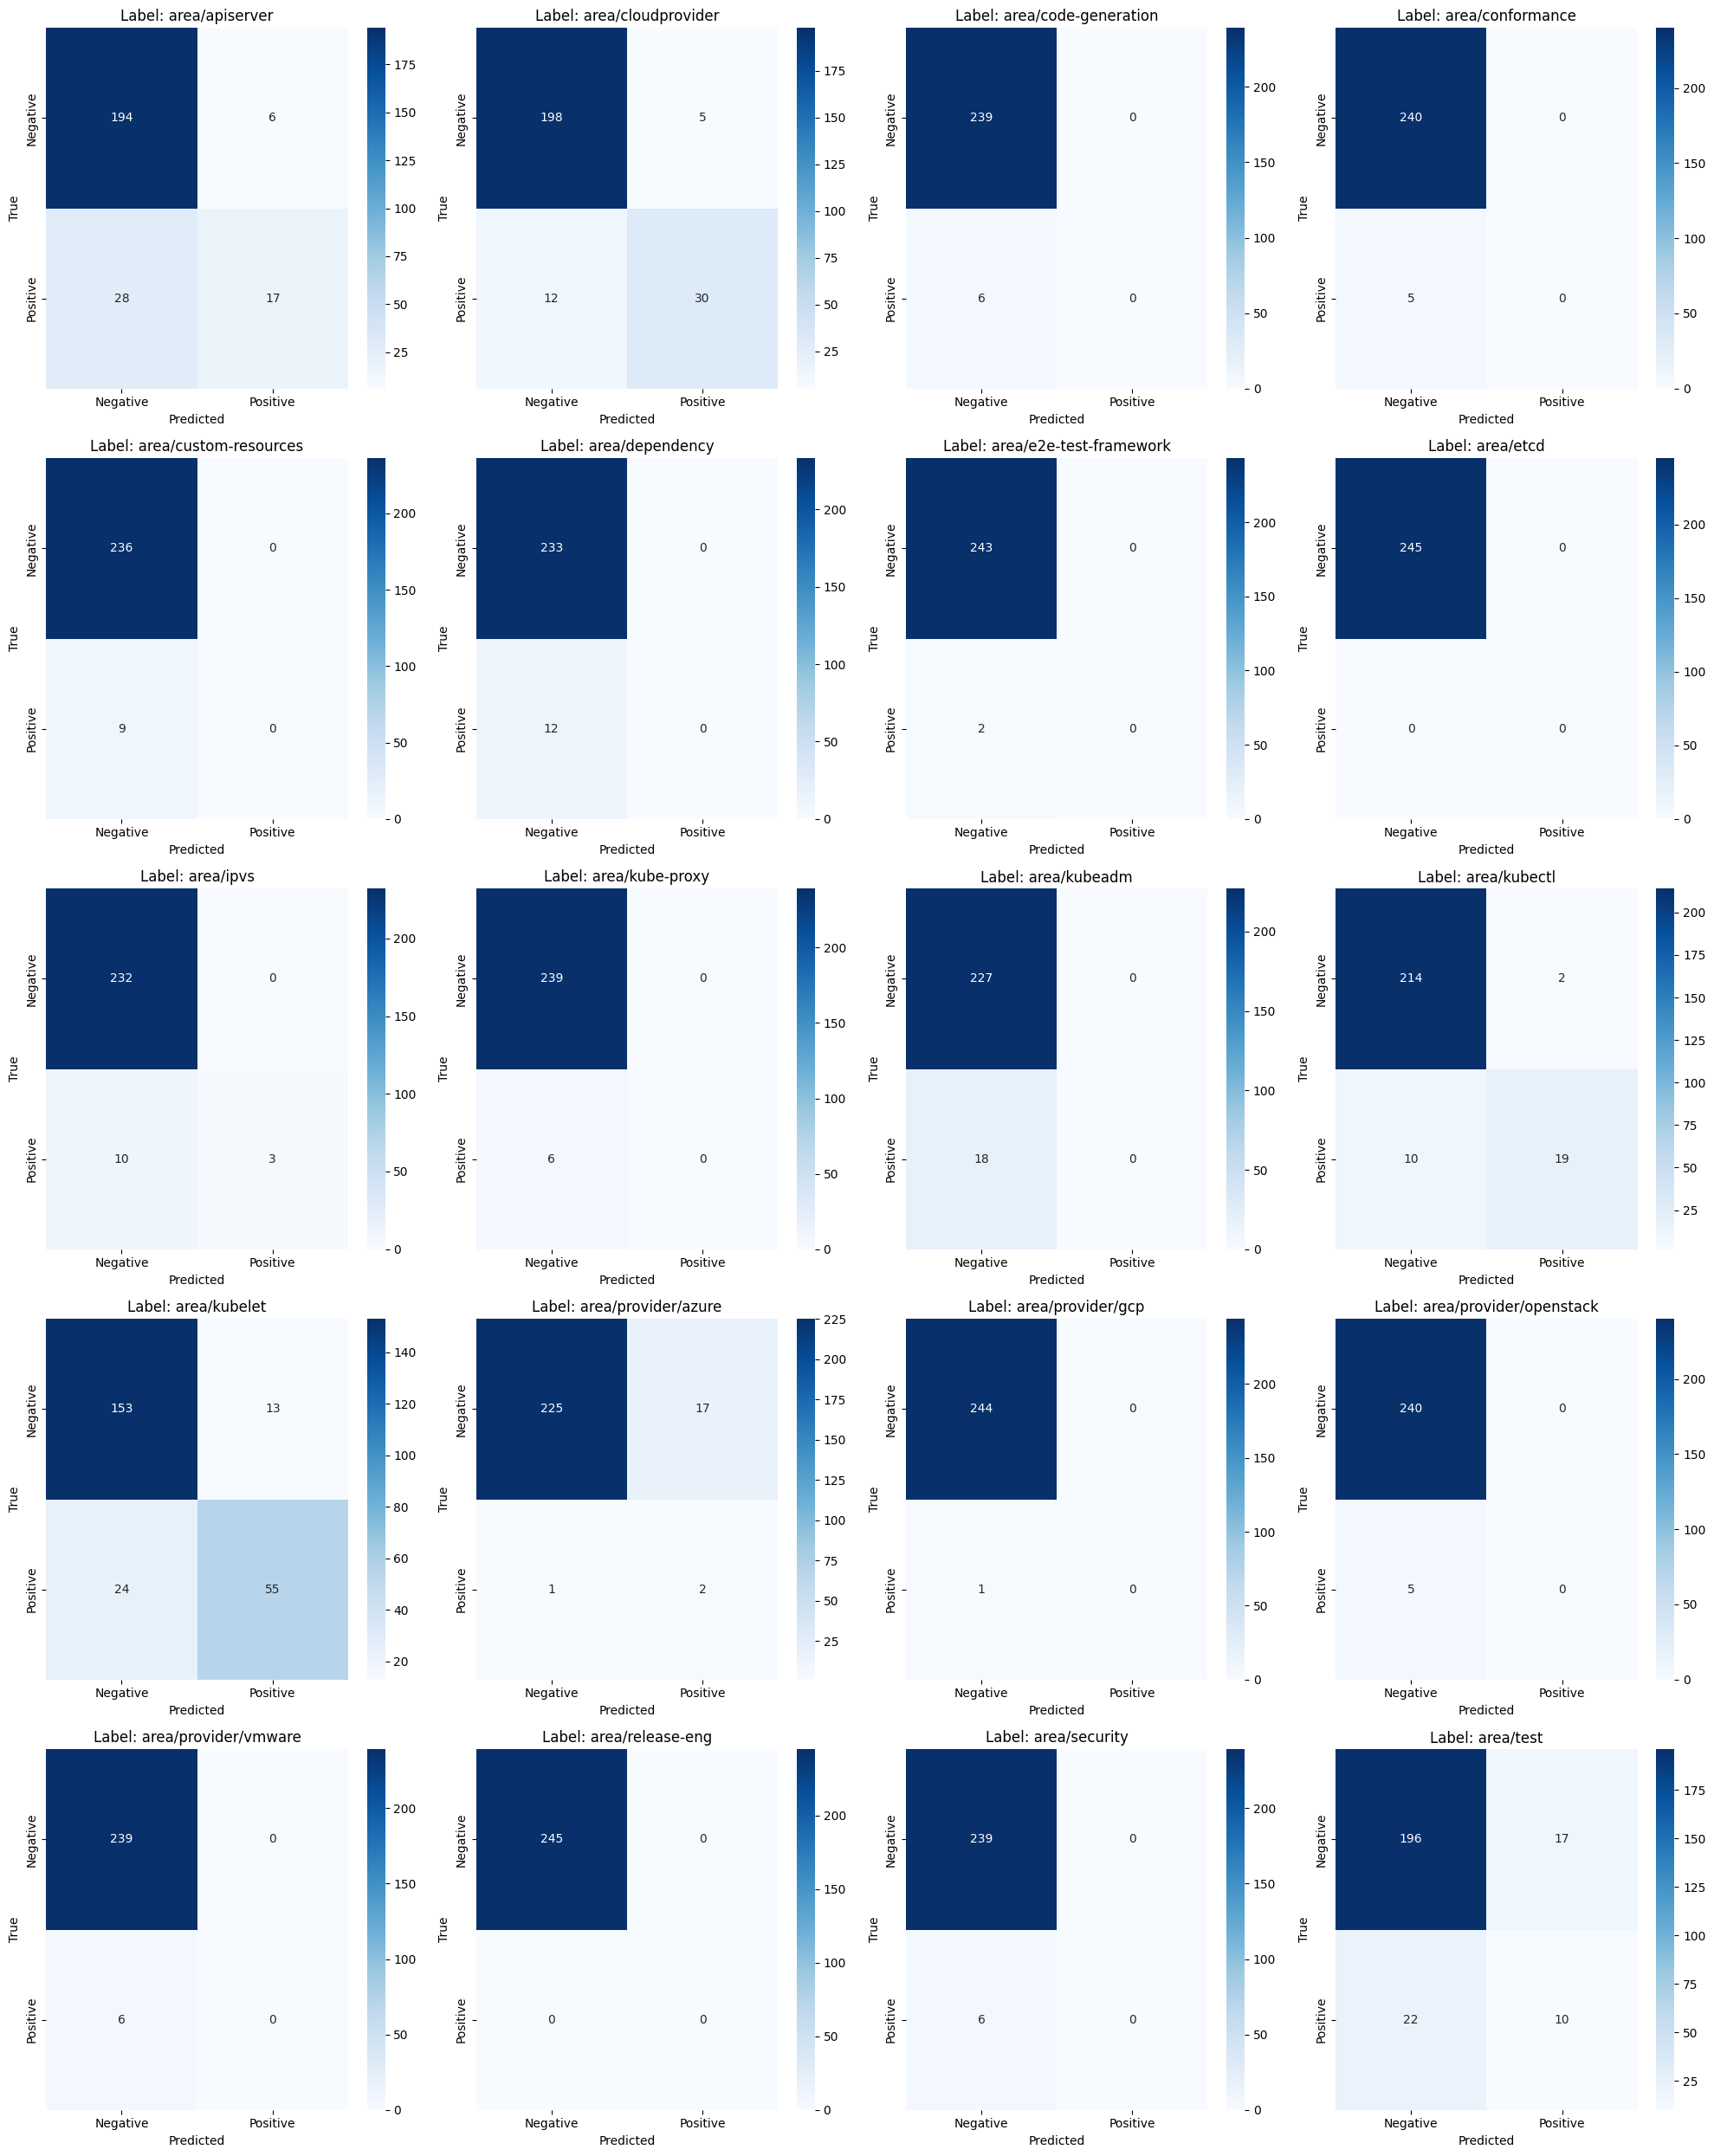

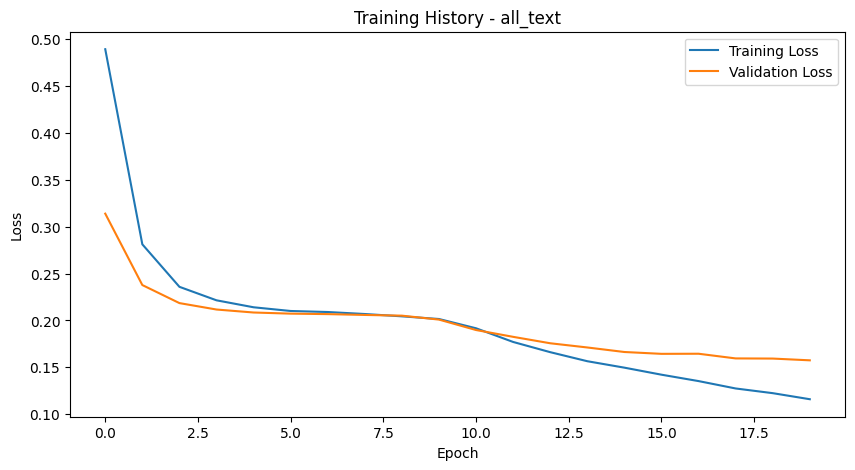

In [14]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train CodeBERT for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-bug-with-reduced-comments-0-3/cleaned_data_with_changed_files_reduced_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=0,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=5, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)